# Music Recommendation System with Contrastive Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load the dataset
df = pd.read_csv('dataset.csv')
df = df.drop_duplicates(subset=['track_id'])
df = df.dropna()

In [5]:
# Audio features for the recommendation system
numerical_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
categorical_features = ['key', 'mode', 'time_signature']

In [6]:
# Normalize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [7]:
# Convert text categories to numbers
label_encoders = {}
for cat_feature in categorical_features:
    le = LabelEncoder()
    df[cat_feature + '_encoded'] = le.fit_transform(df[cat_feature])
    label_encoders[cat_feature] = le

In [8]:
# Organize the final data
all_numerical = numerical_features
all_categorical = [feat + '_encoded' for feat in categorical_features]

df = df.reset_index(drop=True)

# Get numerical & categorical song features
X_numerical = df[all_numerical].values
X_categorical = df[all_categorical].values

## Create slight variations of a song's characteristics
### Why do this? 
Imagine the same song played by different bands, or recorded in different studios.
The core song is the same, but small details might be different. 
This helps the AI learn what makes songs fundamentally similar vs just superficially different.
    
For example:
- Original song: "Happy" by Pharrell Williams
- Light variation: Same song, slightly different recording quality
- Medium variation: Same song, live performance vs studio version
- Strong variation: Same song, acoustic version vs electronic remix

In [10]:
# Audio Augmentation Functions for Contrastive Learning
def apply_audio_augmentation(features, augmentation_type='light', noise_level=0.1):
    augmented = features.copy()

    # Light augmentations - small changes that preserve song identity
    if augmentation_type == 'light':
        noise = np.random.normal(0, noise_level * 0.5, features.shape)
        augmented += noise
        
        # Slight tempo variation (±5%)
        if len(features) > 10:  # tempo is at index 10
            tempo_variation = np.random.uniform(0.95, 1.05)
            augmented[10] *= tempo_variation
        
        # Slight energy variation (±10%)
        if len(features) > 3:  # energy is at index 3
            energy_variation = np.random.uniform(0.9, 1.1)
            augmented[3] *= energy_variation

    # Medium changes - like different arrangements or performance styles
    elif augmentation_type == 'medium':
        noise = np.random.normal(0, noise_level, features.shape)
        augmented += noise
        
        # Tempo variation (±10%)
        if len(features) > 10:
            tempo_variation = np.random.uniform(0.9, 1.1)
            augmented[10] *= tempo_variation
        
        # Energy and valence variations
        if len(features) > 3:
            energy_variation = np.random.uniform(0.8, 1.2)
            augmented[3] *= energy_variation
        
        if len(features) > 9:  # valence is at index 9
            valence_variation = np.random.uniform(0.85, 1.15)
            augmented[9] *= valence_variation

    # Big changes - like major remixes or cover versions
    elif augmentation_type == 'strong':
        noise = np.random.normal(0, noise_level * 1.5, features.shape)
        augmented += noise
        
        # Multiple feature variations
        feature_variations = {
            10: np.random.uniform(0.8, 1.2),  # tempo
            3: np.random.uniform(0.7, 1.3),   # energy
            9: np.random.uniform(0.7, 1.3),   # valence
            2: np.random.uniform(0.9, 1.1),   # danceability
            4: np.random.uniform(0.9, 1.1),   # loudness
        }
        
        for idx, variation in feature_variations.items():
            if len(features) > idx:
                augmented[idx] *= variation
    
    # Clip values to reasonable ranges to prevent extreme outliers
    augmented = np.clip(augmented, -3, 3)  # Assuming standardized features
    
    return augmented

In [11]:
# Create pairs of songs for training the AI
def create_contrastive_pairs(df, num_pairs=10000, positive_ratio=0.5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n = len(df)
    pairs = []
    labels = []

    num_positive = int(num_pairs * positive_ratio)
    num_negative = num_pairs - num_positive

    # positive (same index)
    for _ in range(num_positive):
        idx = np.random.randint(0, n)
        pairs.append((idx, idx))
        labels.append(1)

    # negative (two different indices)
    for _ in range(num_negative):
        i, j = np.random.choice(n, 2, replace=False)
        pairs.append((i, j))
        labels.append(0)

    return np.array(pairs), np.array(labels)

In [12]:
# Create contrastive learning pairs with audio augmentations
pairs, labels = create_contrastive_pairs(df, num_pairs=5000, positive_ratio=0.6)

print(f"Created {len(pairs)} pairs:")
print(f"Positive pairs (augmented): {sum(labels)}")
print(f"Negative pairs (different songs): {len(labels) - sum(labels)}")

Created 5000 pairs:
Positive pairs (augmented): 3000
Negative pairs (different songs): 2000


In [13]:
# Define categorical dimensions
categorical_dims = [
    (len(label_encoders['key'].classes_), 'key'),
    (len(label_encoders['mode'].classes_), 'mode'),
    (len(label_encoders['time_signature'].classes_), 'time_signature'),
]

In [14]:
# Convert the training pairs into the format the AI needs
def prepare_contrastive_data(pairs, labels, X_numerical, X_categorical, augmentation_strength='medium'):
    numerical_a = []
    numerical_b = []
    
    # categorical lists per categorical column
    categorical_a = [[] for _ in range(X_categorical.shape[1])]
    categorical_b = [[] for _ in range(X_categorical.shape[1])]

    for (ia, ib), lab in zip(pairs, labels):
        # For positive pairs: keeps one song original, modifies the other slightly
        if lab == 1:
            orig = X_numerical[ia]
            aug = apply_audio_augmentation(orig, augmentation_type=augmentation_strength, noise_level=0.1)

            # Store original and modified versions
            numerical_a.append(orig)
            numerical_b.append(aug)

            # Keep categorical features the same (genre, key, etc. don't change)
            for j in range(X_categorical.shape[1]):
                val = int(X_categorical[ia, j])
                categorical_a[j].append(val)
                categorical_b[j].append(val)
        else:
            # For negative pairs: keeps both songs as their original selves
            numerical_a.append(X_numerical[ia])
            numerical_b.append(X_numerical[ib])

            for j in range(X_categorical.shape[1]):
                categorical_a[j].append(int(X_categorical[ia, j]))
                categorical_b[j].append(int(X_categorical[ib, j]))

    # Convert to numpy arrays
    numerical_a = np.asarray(numerical_a, dtype=np.float32)
    numerical_b = np.asarray(numerical_b, dtype=np.float32)

    categorical_a = [np.asarray(lst, dtype=np.int32).reshape(-1, 1) for lst in categorical_a]
    categorical_b = [np.asarray(lst, dtype=np.int32).reshape(-1, 1) for lst in categorical_b]

    inputs = [numerical_a] + categorical_a + [numerical_b] + categorical_b

    y = np.asarray(labels, dtype=np.float32)

    # For checking
    n_samples = numerical_a.shape[0]
    assert y.shape[0] == n_samples, "Labels length mismatch"
    for arr in categorical_a + categorical_b:
        assert arr.shape[0] == n_samples, "Categorical column length mismatch"

    return inputs, y

In [15]:
# Split data
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

In [16]:
# Prepare training and validation data with augmentations
X_train, y_train = prepare_contrastive_data(train_pairs, train_labels, X_numerical, X_categorical, 'medium')
X_val, y_val = prepare_contrastive_data(val_pairs, val_labels, X_numerical, X_categorical, 'medium')

print(f"Training data shape: {X_train[0].shape}")
print(f"Validation data shape: {X_val[0].shape}")

Training data shape: (4000, 11)
Validation data shape: (1000, 11)


## MODEL 1: SIMPLE MODEL WITH CONTRASTIVE LEARNING

In [18]:
def create_base_network_simple(num_numerical_features, categorical_dims):
    # Numerical features input
    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
    
    # Categorical features inputs
    categorical_inputs = []
    categorical_embeddings = []
    
    for i, (dim, name) in enumerate(categorical_dims):
        # Each category gets its own input
        cat_input = Input(shape=(1,), name=f'{name}_input')
        # Convert categories to numbers
        embedding = Embedding(input_dim=dim, output_dim=min(5, dim//2 + 1))(cat_input)
        flatten = Flatten()(embedding)
        categorical_inputs.append(cat_input)
        categorical_embeddings.append(flatten)
    
    # Combine numerical and categorical features
    if categorical_embeddings:
        merged = Concatenate()([numerical_input] + categorical_embeddings)
    else:
        merged = numerical_input
    
    # Simple dense layers
    x = Dense(64, activation='relu')(merged)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    
    return Model(inputs=[numerical_input] + categorical_inputs, outputs=x)

# Create a system that can compare two songs
def build_siamese_network_simple(base_network):
    # Create inputs for the first song (Song A)
    numerical_input_a = Input(shape=(len(all_numerical),), name='numerical_a')
    categorical_inputs_a = [
        Input(shape=(1,), name=f'cat_{name}_a') for _, name in categorical_dims
    ]
    
    # Create inputs for the second song (Song B)
    numerical_input_b = Input(shape=(len(all_numerical),), name='numerical_b')
    categorical_inputs_b = [
        Input(shape=(1,), name=f'cat_{name}_b') for _, name in categorical_dims
    ]
    
    # Generate embeddings using shared base network
    embedding_a = base_network([numerical_input_a] + categorical_inputs_a)
    embedding_b = base_network([numerical_input_b] + categorical_inputs_b)
    
    # Compute distance between embeddings
    distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding_a, embedding_b])
    
    # Classification layer
    output = Dense(1, activation='sigmoid')(distance)
    
    return Model(
        inputs=[numerical_input_a] + categorical_inputs_a + [numerical_input_b] + categorical_inputs_b,
        outputs=output
    )

In [19]:
# Create and compile simple model
base_network_simple = create_base_network_simple(len(all_numerical), categorical_dims)
siamese_network_simple = build_siamese_network_simple(base_network_simple)

siamese_network_simple.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

siamese_network_simple.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_a (InputLayer)      │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_key_a (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_mode_a (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_time_signature_a          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_b (InputLayer)      │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_key_b (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_mode_b (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_time_signature_b          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 16)                │           4,095 │ numerical_a[0][0],         │
│                               │                           │                 │ cat_key_a[0][0],           │
│                               │                           │                 │ cat_mode_a[0][0],          │
│                               │                           │                 │ cat_time_signature_a[0][0… │
│                               │                           │                 │ numerical_b[0][0],         │
│                               │                           │                 │ cat_key_b[0][0],           │
│                               │                           │                 │ cat_mode_b[0][0],          │
│                               │                           │                 │ cat_time_signature_b[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 16)                │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │              17 │ lambda[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,112 (16.06 KB)

 Trainable params: 4,112 (16.06 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the simple model
history_simple = siamese_network_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    verbose=1
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4154 - loss: 0.6045 - val_accuracy: 0.4400 - val_loss: 0.5134
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4784 - loss: 0.4997 - val_accuracy: 0.5900 - val_loss: 0.4783
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6140 - loss: 0.4685 - val_accuracy: 0.7410 - val_loss: 0.4539
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7697 - loss: 0.4452 - val_accuracy: 0.8440 - val_loss: 0.4332
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.4247 - val_accuracy: 0.9050 - val_loss: 0.4156
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9308 - loss: 0.4055 - val_accuracy: 0.9640 - val_loss: 0.3969
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9582 - loss: 0.3873 - val_accuracy: 0.9820 - val_loss: 0.3813
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9755 - loss: 0.3708 - val_accuracy: 0.9910 - val_loss:

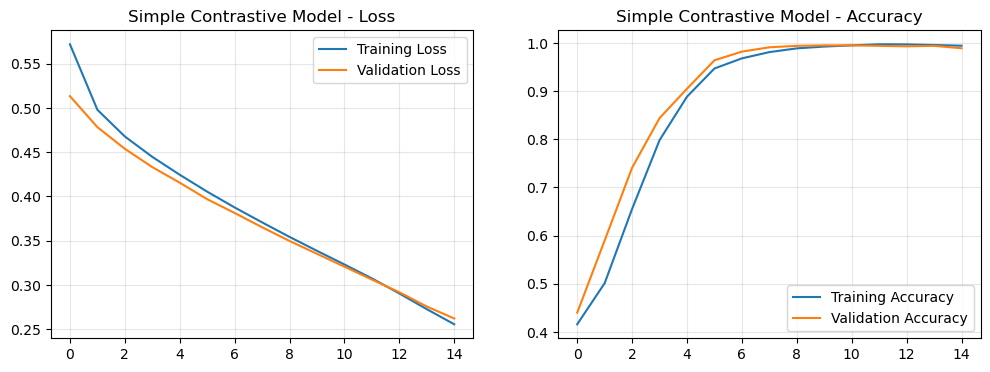

In [21]:
# Plot how well the simple model learned
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['loss'], label='Training Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Simple Contrastive Model - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['accuracy'], label='Training Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple Contrastive Model - Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## MODEL 2: ENHANCED CONTRASTIVE MODEL WITH MULTIPLE AUGMENTATION STRATEGIES

In [23]:
# Create training pairs using multiple augmentation strategies
def create_enhanced_contrastive_pairs(df, X_numerical, X_categorical, num_pairs=10000):
    pairs = []
    labels = []
    augmentation_types = []
    
    # Different strategies for creating song variations
    strategies = [
        ('light', 0.3, 0.7),      # 30%: Subtle recording variations
        ('medium', 0.4, 0.6),     # 40%: Performance arrangement changes  
        ('strong', 0.2, 0.8),     # 20%: Major musical transformations
        ('temporal', 0.1, 0.9)    # 10%: Rhythm and timing variations
    ]
    
    total_created = 0
    
    for strategy, portion, pos_ratio in strategies:
        strategy_pairs = int(num_pairs * portion)
        strategy_positive = int(strategy_pairs * pos_ratio)
        strategy_negative = strategy_pairs - strategy_positive
        
        print(f"Creating {strategy_pairs} pairs with {strategy} strategy...")
        
        # Positive pairs for this strategy
        for _ in range(strategy_positive):
            song_idx = np.random.randint(0, len(df))
            pairs.append((song_idx, song_idx))
            labels.append(1)
            augmentation_types.append(strategy)
        
        # Negative pairs for this strategy
        for _ in range(strategy_negative):
            song1_idx, song2_idx = np.random.choice(len(df), 2, replace=False)
            pairs.append((song1_idx, song2_idx))
            labels.append(0)
            augmentation_types.append('none')
        
        total_created += strategy_pairs
    
    return np.array(pairs), np.array(labels), augmentation_types

# Apply time-based augmentations to simulate performance variations
def apply_temporal_augmentation(features, shift_factor=0.1):
    augmented = features.copy()
    
    # Modify rhythm-related characteristics
    rhythm_indices = [2, 3, 10]  # danceability, energy, tempo
    for idx in rhythm_indices:
        if len(features) > idx:
            temporal_shift = np.random.normal(1.0, shift_factor)
            augmented[idx] *= temporal_shift
    
    # Add small recording differences
    noise = np.random.normal(0, 0.05, features.shape)
    augmented += noise
    
    return np.clip(augmented, -3, 3)

# Prepare enhanced training data with different augmentation strategies
def prepare_enhanced_contrastive_data(pairs, labels, augmentation_types, X_numerical, X_categorical):
    numerical_a = []
    numerical_b = []
    categorical_a = [[] for _ in range(X_categorical.shape[1])]
    categorical_b = [[] for _ in range(X_categorical.shape[1])]
    
    for i, (idx_a, idx_b) in enumerate(pairs):
        if labels[i] == 1:  # Positive pair
            orig_numerical = X_numerical[idx_a]
            orig_categorical = X_categorical[idx_a]
            
            # Apply appropriate augmentation based on strategy
            aug_type = augmentation_types[i]
            if aug_type == 'temporal':
                aug_numerical = apply_temporal_augmentation(orig_numerical)
            else:
                aug_numerical = apply_audio_augmentation(orig_numerical, aug_type)
            
            numerical_a.append(orig_numerical)
            numerical_b.append(aug_numerical)
            
            # Keep categorical features same for positive pairs
            for j in range(X_categorical.shape[1]):
                categorical_a[j].append(orig_categorical[j])
                categorical_b[j].append(orig_categorical[j])
                
        else:  
            # Negative pair
            numerical_a.append(X_numerical[idx_a])
            numerical_b.append(X_numerical[idx_b])
            
            for j in range(X_categorical.shape[1]):
                categorical_a[j].append(X_categorical[idx_a, j])
                categorical_b[j].append(X_categorical[idx_b, j])
    
    # Convert to numpy arrays
    numerical_a = np.array(numerical_a)
    numerical_b = np.array(numerical_b)
    categorical_a = [np.array(cat_list) for cat_list in categorical_a]
    categorical_b = [np.array(cat_list) for cat_list in categorical_b]
    
    inputs = [numerical_a] + categorical_a + [numerical_b] + categorical_b
    return inputs, labels

In [24]:
# Create enhanced training data
enhanced_pairs, enhanced_labels, aug_types = create_enhanced_contrastive_pairs(
    df, X_numerical, X_categorical, num_pairs=6000
)

# Split enhanced data
train_pairs_enh, val_pairs_enh, train_labels_enh, val_labels_enh, train_aug_types, val_aug_types = train_test_split(
    enhanced_pairs, enhanced_labels, aug_types, test_size=0.2, random_state=42, stratify=enhanced_labels
)

# Prepare enhanced training data
X_train_enh, y_train_enh = prepare_enhanced_contrastive_data(
    train_pairs_enh, train_labels_enh, train_aug_types, X_numerical, X_categorical
)
X_val_enh, y_val_enh = prepare_enhanced_contrastive_data(
    val_pairs_enh, val_labels_enh, val_aug_types, X_numerical, X_categorical
)

print(f"Enhanced dataset created: {len(enhanced_pairs)} pairs")
print(f"Positive pairs: {sum(enhanced_labels)}")
print(f"Negative pairs: {len(enhanced_labels) - sum(enhanced_labels)}")

Creating 1800 pairs with light strategy...
Creating 2400 pairs with medium strategy...
Creating 1200 pairs with strong strategy...
Creating 600 pairs with temporal strategy...
Enhanced dataset created: 6000 pairs
Positive pairs: 4200
Negative pairs: 1800


In [25]:
def create_base_network_enhanced(num_numerical_features, categorical_dims):
    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
    
    categorical_inputs = []
    categorical_embeddings = []

    # Enhanced categorical processing with larger embeddings
    for i, (dim, name) in enumerate(categorical_dims):
        cat_input = Input(shape=(1,), name=f'{name}_input')
        embedding = Embedding(input_dim=dim, output_dim=min(8, dim//2 + 1))(cat_input)
        flatten = Flatten()(embedding)
        categorical_inputs.append(cat_input)
        categorical_embeddings.append(flatten)
    
    if categorical_embeddings:
        merged = Concatenate()([numerical_input] + categorical_embeddings)
    else:
        merged = numerical_input
    
    # Enhanced architecture for contrastive learning
    # Randomly ignore 20% of connections during training & Less dropout in later layers
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.2)(x)
    x = Dense(96, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    
    return Model(inputs=[numerical_input] + categorical_inputs, outputs=x)

# Build an enhanced comparison system with multiple similarity measures
def build_enhanced_siamese_network(base_network):
    # Input layers for both songs
    numerical_input_a = Input(shape=(len(all_numerical),), name='numerical_a')
    categorical_inputs_a = [Input(shape=(1,), name=f'cat_{name}_a') for _, name in categorical_dims]
    numerical_input_b = Input(shape=(len(all_numerical),), name='numerical_b')
    categorical_inputs_b = [Input(shape=(1,), name=f'cat_{name}_b') for _, name in categorical_dims]
    
    # Generate embeddings for both songs
    embedding_a = base_network([numerical_input_a] + categorical_inputs_a)
    embedding_b = base_network([numerical_input_b] + categorical_inputs_b)
    
    # Multiple ways to measure similarity
    # L1 distance: Sum of absolute differences
    l1_distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding_a, embedding_b])
    # Euclidean distance: Straight-line distance
    euclidean_distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([embedding_a, embedding_b])
    # Cosine similarity: Whether the songs "point" in the same direction
    cosine_similarity = Lambda(lambda x: K.expand_dims(K.sum(x[0] * x[1], axis=-1) / 
                                                     (K.sqrt(K.sum(K.square(x[0]), axis=-1)) * 
                                                      K.sqrt(K.sum(K.square(x[1]), axis=-1)) + K.epsilon())))([embedding_a, embedding_b])
    
    # Combine distance measures
    combined_features = Concatenate()([l1_distance, euclidean_distance, cosine_similarity])
    
    # Enhanced classification layers with dropout for better generalization
    x = Dense(48, activation='relu')(combined_features)
    x = Dropout(0.1)(x)
    x = Dense(24, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    return Model(
        inputs=[numerical_input_a] + categorical_inputs_a + [numerical_input_b] + categorical_inputs_b,
        outputs=output
    )

In [26]:
# Create and compile enhanced model
base_network_enhanced = create_base_network_enhanced(len(all_numerical), categorical_dims)
siamese_network_enhanced = build_enhanced_siamese_network(base_network_enhanced)

siamese_network_enhanced.compile(
    optimizer=Adam(learning_rate=0.0005), # Slower learning rate for better stability
    loss='binary_crossentropy',
    metrics=['accuracy']
)

siamese_network_enhanced.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_a (InputLayer)      │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_key_a (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_mode_a (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_time_signature_a          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_b (InputLayer)      │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_key_b (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_mode_b (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_time_signature_b          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_2 (Functional)     │ (None, 32)                │          23,847 │ numerical_a[0][0],         │
│                               │                           │                 │ cat_key_a[0][0],           │
│                               │                           │                 │ cat_mode_a[0][0],          │
│                               │                           │                 │ cat_time_signature_a[0][0… │
│                               │                           │                 │ numerical_b[0][0],         │
│                               │                           │                 │ cat_key_b[0][0],           │
│                               │                           │                 │ cat_mode_b[0][0],          │
│                               │                           │                 │ cat_time_signature_b[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1 (Lambda)             │ (None, 32)                │               0 │ functional_2[0][0],        │
│                               │                           │                 │ functional_2[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_2 (Lambda)             │ (None, 1)                 │               0 │ functional_2[0][0],        │
│                               │                           │                 │ functional_2[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_3 (Lambda)             │ (None, 1)                 │               

 Total params: 26,728 (104.41 KB)

 Trainable params: 26,728 (104.41 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train enhanced contrastive model
history_enhanced = siamese_network_enhanced.fit(
    X_train_enh, y_train_enh,
    validation_data=(X_val_enh, y_val_enh),
    epochs=25, # More training rounds for better learning
    batch_size=128, # Larger batches for more stable training
    verbose=1
)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5915 - loss: 0.6822 - val_accuracy: 0.7008 - val_loss: 0.6591
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7114 - loss: 0.6170 - val_accuracy: 0.8150 - val_loss: 0.5579
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.4863 - val_accuracy: 0.8808 - val_loss: 0.4240
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8738 - loss: 0.3557 - val_accuracy: 0.9125 - val_loss: 0.3359
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8983 - loss: 0.3016 - val_accuracy: 0.9333 - val_loss: 0.2737
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9056 - loss: 0.2806 - val_accuracy: 0.9333 - val_loss: 0.2429
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9184 - loss: 0.2540 - val_accuracy: 0.9408 - val_loss: 0.2192
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.2344 - val_accuracy: 0.9517 - val_loss

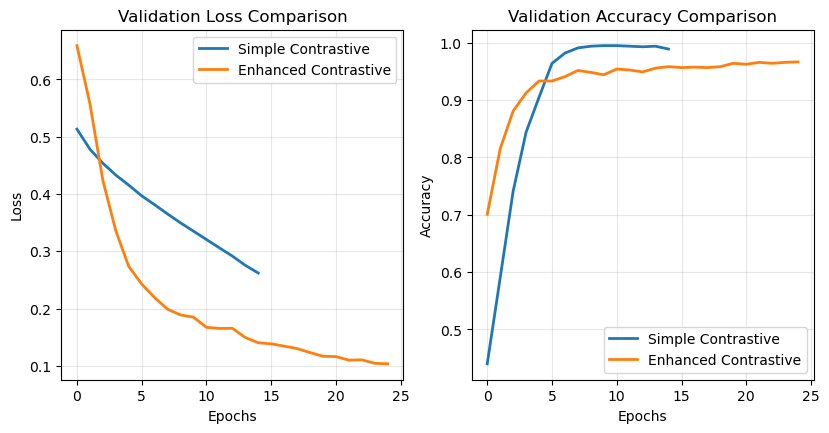

In [28]:
# Compare models (Simple vs Enhanced)
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 3, 1)
plt.plot(history_simple.history['val_loss'], label='Simple Contrastive', linewidth=2)
plt.plot(history_enhanced.history['val_loss'], label='Enhanced Contrastive', linewidth=2)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy comparison
plt.subplot(2, 3, 2)
plt.plot(history_simple.history['val_accuracy'], label='Simple Contrastive', linewidth=2)
plt.plot(history_enhanced.history['val_accuracy'], label='Enhanced Contrastive', linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Final metrics comparison
final_metrics = {
    'Simple Contrastive': {
        'val_loss': history_simple.history['val_loss'][-1],
        'val_accuracy': history_simple.history['val_accuracy'][-1],
        'train_loss': history_simple.history['loss'][-1],
        'train_accuracy': history_simple.history['accuracy'][-1]
    },
    'Enhanced Contrastive': {
        'val_loss': history_enhanced.history['val_loss'][-1],
        'val_accuracy': history_enhanced.history['val_accuracy'][-1],
        'train_loss': history_enhanced.history['loss'][-1],
        'train_accuracy': history_enhanced.history['accuracy'][-1]
    }
}

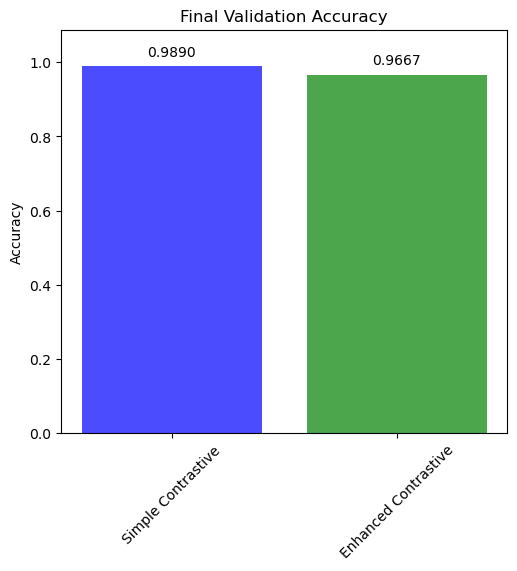

In [29]:
# Final accuracy comparison bar chart
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 5)

models = list(final_metrics.keys())
val_accuracies = [final_metrics[model]['val_accuracy'] for model in models]
colors = ['blue', 'green']

bars = plt.bar(models, val_accuracies, color=colors, alpha=0.7)
plt.title('Final Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.ylim(0, max(val_accuracies) * 1.1)
for bar, accuracy in zip(bars, val_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

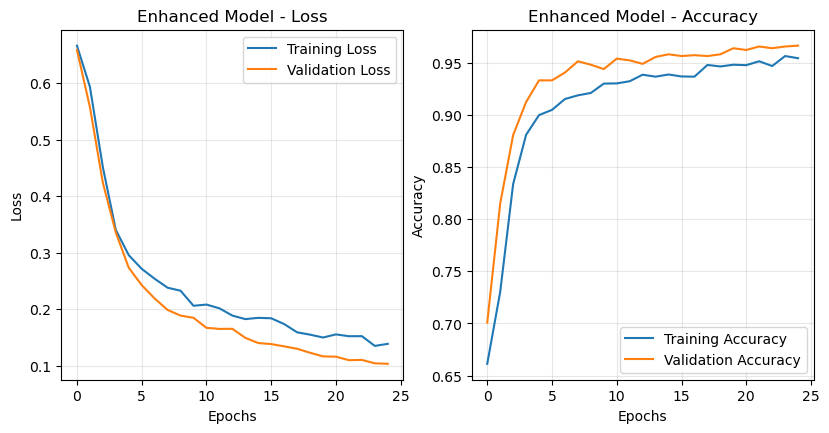

In [30]:
# Training curves for enhanced model
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 4)
plt.plot(history_enhanced.history['loss'], label='Training Loss')
plt.plot(history_enhanced.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.plot(history_enhanced.history['accuracy'], label='Training Accuracy')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

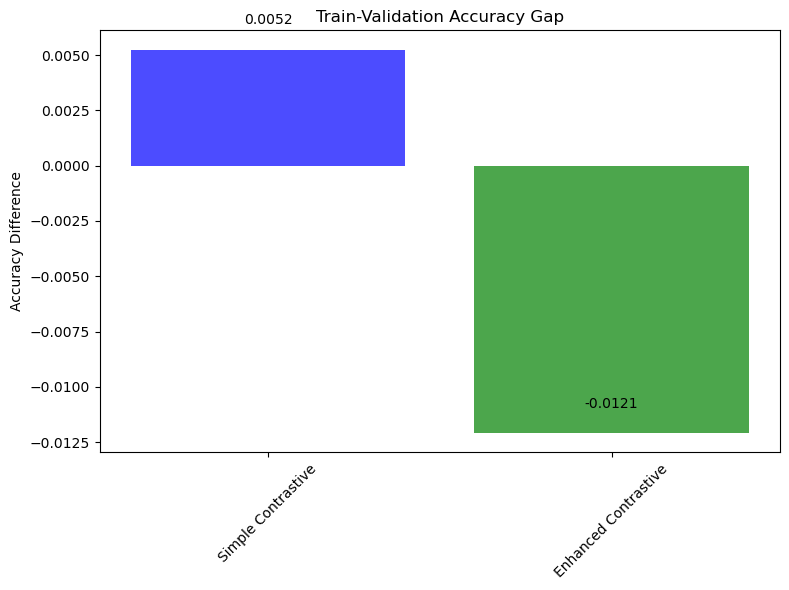

In [31]:
# Overfitting analysis - gap between training and validation performance
plt.figure(figsize=(8, 6))
train_val_gaps = []
for model in models:
    train_acc = final_metrics[model]['train_accuracy']
    val_acc = final_metrics[model]['val_accuracy']
    train_val_gaps.append(train_acc - val_acc)

bars = plt.bar(models, train_val_gaps, color=colors, alpha=0.7)
plt.title('Train-Validation Accuracy Gap')
plt.ylabel('Accuracy Difference')
plt.xticks(rotation=45)
for bar, gap in zip(bars, train_val_gaps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{gap:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [32]:
# Performance Comparison (Simple & Enhanced)
comparison = pd.DataFrame([
    {
        "Model": model,
        "Val Loss": final_metrics[model]['val_loss'],
        "Val Acc": final_metrics[model]['val_accuracy'],
        "Train Acc": final_metrics[model]['train_accuracy'],
        "Overfit Gap": final_metrics[model]['train_accuracy'] - final_metrics[model]['val_accuracy']
    }
    for model in models
])

# Round for readability
comparison = comparison.round(4)

print(comparison)

best_model_name = comparison.loc[comparison["Val Acc"].idxmax(), "Model"]
print(f"\nBest performing model: {best_model_name} "
      f"(Val Acc: {comparison['Val Acc'].max():.4f})")

                  Model  Val Loss  Val Acc  Train Acc  Overfit Gap
0    Simple Contrastive    0.2621   0.9890     0.9942       0.0052
1  Enhanced Contrastive    0.1037   0.9667     0.9546      -0.0121

Best performing model: Simple Contrastive (Val Acc: 0.9890)


In [33]:
# Create Embeddings for Recommendation System

# Select the best model for recommendations
if best_model_name == 'Simple Contrastive':
    best_base_network = base_network_simple
    print("Using Simple Contrastive model for recommendations")
else:
    best_base_network = base_network_enhanced
    print("Using Enhanced Contrastive model for recommendations")

def generate_song_embeddings(base_network, X_numerical, X_categorical):
    # Prepare inputs for the base network
    numerical_inputs = X_numerical
    categorical_inputs = [X_categorical[:, i] for i in range(X_categorical.shape[1])]
    
    # Generate embeddings
    inputs = [numerical_inputs] + categorical_inputs
    embeddings = base_network.predict(inputs, batch_size=512, verbose=1)
    
    return embeddings

# Generate embeddings
song_embeddings = generate_song_embeddings(best_base_network, X_numerical, X_categorical)
print(f"Generated embeddings shape: {song_embeddings.shape}")

# Create nearest neighbors model for recommendations
recommender = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
recommender.fit(song_embeddings)

Using Simple Contrastive model for recommendations
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Generated embeddings shape: (89740, 16)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [34]:
# RECOMMENDATION FUNCTIONS WITH CONTRASTIVE LEARNING

# Get recommendations using contrastive learning embeddings
def get_contrastive_recommendations(track_id, df, recommender, song_embeddings, 
                                  preferences=None, n_recommendations=5, 
                                  diversity_factor=0.1):
    """
    Args:
        track_id: ID of the input track
        df: DataFrame with song data
        recommender: Trained NearestNeighbors model
        song_embeddings: Pre-computed song embeddings
        preferences: Optional user preferences
        n_recommendations: Number of recommendations to return
        diversity_factor: Factor to promote diversity (0.0 = pure similarity, 1.0 = pure diversity)
    """
    
    # Find the track in the dataset
    song_idx = df[df['track_id'] == track_id].index
    if len(song_idx) == 0:
        print(f"Error: track_id '{track_id}' not found in dataset!")
        return None
    
    song_idx = song_idx[0]
    input_embedding = song_embeddings[song_idx].reshape(1, -1)
    input_song = df.iloc[song_idx]
    
    print(f"🎵 Input song: {input_song['track_name']} by {input_song['artists']}")
    print(f"   Album: {input_song['album_name']}")
    print(f"   Genre: {input_song['track_genre']}, Track ID: {track_id}")
    print(f"   Audio Features:")
    print(f"   - Energy: {input_song['energy']:.3f}, Valence: {input_song['valence']:.3f}")
    print(f"   - Danceability: {input_song['danceability']:.3f}, Tempo: {input_song['tempo']:.1f}")
    print()
    
    # Get initial candidates (more than needed for diversity filtering)
    n_candidates = min(100, len(df))
    distances, indices = recommender.kneighbors(input_embedding, n_neighbors=n_candidates)
    
    candidate_indices = indices[0][1:]
    candidate_distances = distances[0][1:]
    
    # Apply preference filtering if provided
    filtered_candidates = []
    for idx, dist in zip(candidate_indices, candidate_distances):
        song = df.iloc[idx]
        similarity = 1 - dist
        
        # Check preferences
        if preferences and not check_contrastive_preferences(song, preferences):
            continue
            
        filtered_candidates.append({
            'idx': idx,
            'similarity': similarity,
            'distance': dist,
            'song': song
        })
    
    if not filtered_candidates:
        print("No songs matched your preferences. Showing most similar songs:")
        filtered_candidates = [{'idx': idx, 'similarity': 1-dist, 'distance': dist, 'song': df.iloc[idx]} 
                             for idx, dist in zip(candidate_indices[:10], candidate_distances[:10])]
    
    # Apply diversity-aware selection
    if diversity_factor > 0 and len(filtered_candidates) > n_recommendations:
        selected_candidates = diversity_aware_selection(
            filtered_candidates, song_embeddings, n_recommendations, diversity_factor
        )
    else:
        # Simple similarity-based selection
        selected_candidates = sorted(filtered_candidates, 
                                   key=lambda x: x['similarity'], reverse=True)[:n_recommendations]
    
    # Show recommendations
    recommendations = []
    print(f"🎯 Contrastive Learning Recommendations ({len(selected_candidates)}):")
    print("=" * 100)
    
    for i, candidate in enumerate(selected_candidates):
        song = candidate['song']
        similarity = candidate['similarity']
        
        rec_data = {
            'track_id': song['track_id'],
            'track_name': song['track_name'],
            'artists': song['artists'],
            'album_name': song['album_name'],
            'genre': song['track_genre'],
            'similarity': similarity,
            'energy': song['energy'],
            'valence': song['valence'],
            'danceability': song['danceability'],
            'tempo': song['tempo'],
            'acousticness': song['acousticness'],
            'instrumentalness': song['instrumentalness'],
            'loudness': song['loudness'],
            'speechiness': song['speechiness']
        }
        
        recommendations.append(rec_data)
        
        print(f"{i+1}. 🎵 {rec_data['track_name']} by {rec_data['artists']}")
        print(f"   📀 Album: {rec_data['album_name']}")
        print(f"   🎭 Genre: {rec_data['genre']} | 📊 Similarity: {similarity:.3f}")
        print(f"   🎹 Features: Energy {rec_data['energy']:.3f} | Valence {rec_data['valence']:.3f} | Dance {rec_data['danceability']:.3f}")
        print(f"   🎼 Tempo: {rec_data['tempo']:.1f} BPM | Acoustic: {rec_data['acousticness']:.3f}")
        
        # Generate explanation
        explanation = generate_contrastive_explanation(input_song, song, similarity)
        print(f"   💡 Why recommended: {explanation}")
        print()
    
    return recommendations

# Check if a song matches user preferences
def check_contrastive_preferences(song, preferences):
    if not preferences:
        return True
    
    # Genre preference
    if 'genre' in preferences and preferences['genre']:
        preferred_genres = [g.lower() for g in preferences['genre']]
        song_genre = song['track_genre'].lower()
        if not any(pref in song_genre or song_genre in pref for pref in preferred_genres):
            return False
    
    # Energy level preference
    if 'energy_level' in preferences:
        energy = song['energy']
        if preferences['energy_level'] == 'low' and energy > 0.5:
            return False
        elif preferences['energy_level'] == 'high' and energy < 0.5:
            return False
        elif preferences['energy_level'] == 'medium' and (energy < 0.3 or energy > 0.7):
            return False
    
    # Valence (mood) preference
    if 'mood' in preferences:
        valence = song['valence']
        if preferences['mood'] == 'happy' and valence < 0.5:
            return False
        elif preferences['mood'] == 'sad' and valence > 0.5:
            return False
    
    # Tempo preference
    if 'tempo_range' in preferences:
        tempo = song['tempo']
        min_tempo, max_tempo = preferences['tempo_range']
        if tempo < min_tempo or tempo > max_tempo:
            return False
    
    return True

# Select recommendations balancing similarity and diversity
def diversity_aware_selection(candidates, embeddings, n_recommendations, diversity_factor):
    if len(candidates) <= n_recommendations:
        return candidates
    
    selected = []
    remaining = candidates.copy()
    
    # Always select the most similar song first
    most_similar = max(remaining, key=lambda x: x['similarity'])
    selected.append(most_similar)
    remaining.remove(most_similar)
    
    # Select remaining songs balancing similarity and diversity
    while len(selected) < n_recommendations and remaining:
        best_candidate = None
        best_score = -float('inf')
        
        for candidate in remaining:
            # Similarity score
            similarity_score = candidate['similarity']
            
            # Diversity score (average distance from already selected songs)
            if len(selected) > 0:
                candidate_embedding = embeddings[candidate['idx']]
                selected_embeddings = [embeddings[s['idx']] for s in selected]
                
                # Calculate average cosine distance from selected songs
                distances = [
                    1 - np.dot(candidate_embedding, sel_emb) / 
                    (np.linalg.norm(candidate_embedding) * np.linalg.norm(sel_emb))
                    for sel_emb in selected_embeddings
                ]
                diversity_score = np.mean(distances)
            else:
                diversity_score = 0
            
            # Combined score
            combined_score = (1 - diversity_factor) * similarity_score + diversity_factor * diversity_score
            
            if combined_score > best_score:
                best_score = combined_score
                best_candidate = candidate
        
        if best_candidate:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
    
    return selected

# Generate explanation for why a song was recommended using contrastive learning
def generate_contrastive_explanation(input_song, recommended_song, similarity):

    explanations = []
    
    # High similarity explanation
    if similarity > 0.8:
        explanations.append("Very similar audio characteristics learned through contrastive training")
    elif similarity > 0.6:
        explanations.append("Similar musical patterns identified by the neural network")
    else:
        explanations.append("Complementary musical features discovered through contrastive learning")
    
    # Genre-based explanation
    if input_song['track_genre'] == recommended_song['track_genre']:
        explanations.append(f"same genre ({input_song['track_genre']})")
    
    # Audio feature explanations
    energy_diff = abs(input_song['energy'] - recommended_song['energy'])
    valence_diff = abs(input_song['valence'] - recommended_song['valence'])
    dance_diff = abs(input_song['danceability'] - recommended_song['danceability'])
    
    if energy_diff < 0.2:
        explanations.append("similar energy levels")
    if valence_diff < 0.2:
        explanations.append("matching mood/valence")
    if dance_diff < 0.2:
        explanations.append("comparable danceability")
    
    # Tempo similarity
    tempo_diff = abs(input_song['tempo'] - recommended_song['tempo'])
    if tempo_diff < 20:
        explanations.append("similar tempo")
    
    return ", ".join(explanations[:3])

In [35]:
# Testing Recommendation System
CONTRASTIVE_PREFERENCES = {
    'energetic_dance': {
        'energy_level': 'high',
        'genre': ['pop', 'dance', 'electronic'],
        'mood': 'happy'
    },
    'chill_acoustic': {
        'energy_level': 'low',
        'genre': ['acoustic', 'folk', 'indie'],
        'mood': 'medium'
    },
    'any_similar': {
        # No specific preferences - pure similarity
    },
    'diverse_mix': {
        'genre': ['pop', 'rock', 'electronic', 'hip-hop', 'jazz']
    }
}

# Get a few sample track IDs for demonstration
sample_tracks = df.head(5)['track_id'].tolist()
print("Sample tracks available for testing:")
for i, track_id in enumerate(sample_tracks):
    song_info = df[df['track_id'] == track_id].iloc[0]
    print(f"{i+1}. {song_info['track_name']} by {song_info['artists']} (Genre: {song_info['track_genre']})")

print("\nAvailable preference presets:")
for preset_name, preset_prefs in CONTRASTIVE_PREFERENCES.items():
    print(f"- {preset_name}: {preset_prefs}")


# Example usage of contrastive learning recommendations
print("\n" + "="*80)
print("🎵 CONTRASTIVE LEARNING RECOMMENDATION EXAMPLES")
print("="*80)

# Use the first sample track for demonstration
demo_track_id = sample_tracks[0]

# Example 1: Pure similarity-based recommendations
print("\nA. 🎯 PURE SIMILARITY (No Preferences)")
print("-" * 50)
recommendations_pure = get_contrastive_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=None, n_recommendations=3, diversity_factor=0.0
)

# Example 2: With preferences
print("\nB. 🎭 WITH PREFERENCES (Energetic Dance)")
print("-" * 50)
recommendations_pref = get_contrastive_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=CONTRASTIVE_PREFERENCES['energetic_dance'], 
    n_recommendations=3, diversity_factor=0.0
)

# Example 3: Diversity-aware recommendations
print("\nC. 🌈 DIVERSITY-AWARE RECOMMENDATIONS")
print("-" * 50)
recommendations_diverse = get_contrastive_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=None, n_recommendations=3, diversity_factor=0.3
)

Sample tracks available for testing:
1. Comedy by Gen Hoshino (Genre: acoustic)
2. Ghost - Acoustic by Ben Woodward (Genre: acoustic)
3. To Begin Again by Ingrid Michaelson;ZAYN (Genre: acoustic)
4. Can't Help Falling In Love by Kina Grannis (Genre: acoustic)
5. Hold On by Chord Overstreet (Genre: acoustic)

Available preference presets:
- energetic_dance: {'energy_level': 'high', 'genre': ['pop', 'dance', 'electronic'], 'mood': 'happy'}
- chill_acoustic: {'energy_level': 'low', 'genre': ['acoustic', 'folk', 'indie'], 'mood': 'medium'}
- any_similar: {}
- diverse_mix: {'genre': ['pop', 'rock', 'electronic', 'hip-hop', 'jazz']}

🎵 CONTRASTIVE LEARNING RECOMMENDATION EXAMPLES

A. 🎯 PURE SIMILARITY (No Preferences)
--------------------------------------------------
🎵 Input song: Comedy by Gen Hoshino
   Album: Comedy
   Genre: acoustic, Track ID: 5SuOikwiRyPMVoIQDJUgSV
   Audio Features:
   - Energy: -0.676, Valence: 0.934
   - Danceability: 0.644, Tempo: -1.1

🎯 Contrastive Learning Reco

## HYPERPARAMETER TUNING

In [37]:
import itertools
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization
import tempfile
import os

In [38]:
# Hyperparameter tuning setup
param_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005], # How fast to learn
    'batch_size': [128, 256, 512], # How many examples at once
    'dropout_1': [0.2, 0.3, 0.4], # First layer forgetting rate
    'dropout_2': [0.1, 0.2, 0.3], # Second layer forgetting rate
    'hidden_dim_1': [128, 256, 512], # First layer size
    'hidden_dim_2': [64, 128, 256], # Second layer size
    'embedding_dim': [8, 12, 16], # Category representation size
    'l2_reg': [0.001, 0.01, 0.1] # Complexity penalty
}

In [39]:
# Create the most advanced version of the music understanding brain
def create_advanced_base_network(num_numerical_features, categorical_dims, 
                               hidden_dim_1=256, hidden_dim_2=128, hidden_dim_3=64,
                               dropout_1=0.3, dropout_2=0.2, dropout_3=0.1,
                               embedding_dim=12, l2_reg=0.01, use_batch_norm=True):

    # Input for numerical features with regularization
    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
    
    # Advanced categorical embeddings with regularization
    categorical_inputs = []
    categorical_embeddings = []
    
    for i, (dim, name) in enumerate(categorical_dims):
        cat_input = Input(shape=(1,), name=f'{name}_input')
        embedding = Embedding(
            input_dim=dim, 
            output_dim=min(embedding_dim, dim//2 + 1),
            embeddings_regularizer=l1_l2(l1=0.0, l2=l2_reg/10) # Prevent overfitting
        )(cat_input)
        flatten = Flatten()(embedding)
        categorical_inputs.append(cat_input)
        categorical_embeddings.append(flatten)
    
    # Merge all features
    if categorical_embeddings:
        merged = Concatenate()([numerical_input] + categorical_embeddings)
    else:
        merged = numerical_input
    
    # Advanced architecture with batch normalization and residual connections
    # First thinking block
    x1 = Dense(hidden_dim_1, activation='relu', 
               kernel_regularizer=l1_l2(l1=0.0, l2=l2_reg))(merged)
    if use_batch_norm:
        x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout_1)(x1)
    
    # Second block with potential residual connection
    x2 = Dense(hidden_dim_2, activation='relu',
               kernel_regularizer=l1_l2(l1=0.0, l2=l2_reg))(x1)
    if use_batch_norm:
        x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout_2)(x2)
    
    # Add residual connection if dimensions match
    if hidden_dim_1 == hidden_dim_2:
        x2 = tf.keras.layers.Add()([x1, x2])
    
    # Third block
    x3 = Dense(hidden_dim_3, activation='relu',
               kernel_regularizer=l1_l2(l1=0.0, l2=l2_reg))(x2)
    if use_batch_norm:
        x3 = BatchNormalization()(x3)
    x3 = Dropout(dropout_3)(x3)
    
    # Output layer with L2 normalization for better similarity computation
    output = Dense(32, activation='linear',
                   kernel_regularizer=l1_l2(l1=0.0, l2=l2_reg))(x3)
    output = Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(output)  # L2 normalize embeddings
    
    return Model(inputs=[numerical_input] + categorical_inputs, outputs=output)

# Build the most sophisticated comparison system
def build_advanced_siamese_network(base_network):
    # Input layers for both songs
    numerical_input_a = Input(shape=(len(all_numerical),), name='numerical_a')
    categorical_inputs_a = [Input(shape=(1,), name=f'cat_{name}_a') for _, name in categorical_dims]
    numerical_input_b = Input(shape=(len(all_numerical),), name='numerical_b')
    categorical_inputs_b = [Input(shape=(1,), name=f'cat_{name}_b') for _, name in categorical_dims]
    
    # Generate L2-normalized embeddings
    embedding_a = base_network([numerical_input_a] + categorical_inputs_a)
    embedding_b = base_network([numerical_input_b] + categorical_inputs_b)
    
    # Advanced distance measures
    # 1. L1 distance: Sum of absolute differences
    l1_distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding_a, embedding_b])
    
    # 2. L2 distance: Straight-line distance in high-dimensional space
    euclidean_distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([embedding_a, embedding_b])
    
    # 3. Cosine similarity
    cosine_similarity = Lambda(lambda x: K.expand_dims(K.sum(x[0] * x[1], axis=-1)))([embedding_a, embedding_b])
    
    # 4. Element-wise product: How features align
    hadamard_product = Lambda(lambda x: x[0] * x[1])([embedding_a, embedding_b])
    
    # 5. Squared differences: Emphasizes larger differences
    squared_diff = Lambda(lambda x: K.square(x[0] - x[1]))([embedding_a, embedding_b])
    
    # Combine all distance measures
    combined_features = Concatenate()([
        l1_distance, euclidean_distance, cosine_similarity, 
        hadamard_product, squared_diff
    ])
    
    # Advanced classification head with batch normalization and residual connections
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0, l2=0.01))(combined_features)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x2 = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0, l2=0.01))(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.1)(x2)
    
    x3 = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.0, l2=0.01))(x2)
    x3 = Dropout(0.05)(x3)
    
    # Final classification layer
    output = Dense(1, activation='sigmoid')(x3)
    
    return Model(
        inputs=[numerical_input_a] + categorical_inputs_a + [numerical_input_b] + categorical_inputs_b,
        outputs=output
    )

# Find the best settings
def train_with_hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid, max_trials=12):
    print(f"Total possible combinations: {len(list(ParameterGrid(param_grid)))}")
    print(f"Testing {max_trials} combinations\n")
    
    # Create parameter combinations and sample randomly
    all_params = list(ParameterGrid(param_grid))
    np.random.shuffle(all_params)
    selected_params = all_params[:max_trials]
    
    best_score = -1
    best_params = None
    best_model = None
    best_history = None
    
    results = []
    
    for i, params in enumerate(selected_params):
        print(f"\nTrial {i+1}/{max_trials}")
        print(f"Parameters: {params}")
        print("-" * 50)
        
        try:
            # Create model with current parameters
            base_network = create_advanced_base_network(
                len(all_numerical), categorical_dims,
                hidden_dim_1=params['hidden_dim_1'],
                hidden_dim_2=params['hidden_dim_2'],
                dropout_1=params['dropout_1'],
                dropout_2=params['dropout_2'],
                embedding_dim=params['embedding_dim'],
                l2_reg=params['l2_reg']
            )
            
            siamese_network = build_advanced_siamese_network(base_network)
            
            # Compile with current learning rate
            siamese_network.compile(
                optimizer=Adam(learning_rate=params['learning_rate']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Advanced callbacks
            # Stop early if it's not improving
            callbacks = [
                EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,
                    restore_best_weights=True,
                    verbose=0
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-7,
                    verbose=0
                )
            ]
            
            # Train model
            history = siamese_network.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=20,
                batch_size=params['batch_size'],
                callbacks=callbacks,
                verbose=0
            )
            
            # Evaluate performance
            val_accuracy = max(history.history['val_accuracy'])
            val_loss = min(history.history['val_loss'])
            
            # Check for overfitting
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            overfitting_penalty = max(0, (final_train_acc - final_val_acc - 0.05)) * 0.1
            
            # Adjusted score accounting for overfitting
            adjusted_score = val_accuracy - overfitting_penalty
            
            print(f"Validation Accuracy: {val_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Overfitting Penalty: {overfitting_penalty:.4f}")
            print(f"Adjusted Score: {adjusted_score:.4f}")
            
            # Store results
            results.append({
                'params': params.copy(),
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
                'adjusted_score': adjusted_score,
                'overfitting_penalty': overfitting_penalty
            })
            
            # Update best model
            if adjusted_score > best_score:
                best_score = adjusted_score
                best_params = params.copy()
                best_model = siamese_network
                best_history = history
                print("*** NEW BEST MODEL ***")
            
        except Exception as e:
            print(f"Error in trial {i+1}: {str(e)}")
            continue
    
    print(f"\nHyperparameter tuning completed!")
    print(f"Best adjusted score: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_model, best_params, best_history, results

In [40]:
# Create advanced model
advanced_pairs, advanced_labels, advanced_aug_types = create_enhanced_contrastive_pairs(
    df, X_numerical, X_categorical, num_pairs=8000
)

# Split the data
train_pairs_adv, val_pairs_adv, train_labels_adv, val_labels_adv, train_aug_adv, val_aug_adv = train_test_split(
    advanced_pairs, advanced_labels, advanced_aug_types, 
    test_size=0.2, random_state=42, stratify=advanced_labels
)

Creating 2400 pairs with light strategy...
Creating 3200 pairs with medium strategy...
Creating 1600 pairs with strong strategy...
Creating 800 pairs with temporal strategy...


In [41]:
# Prepare the data
X_train_adv, y_train_adv = prepare_enhanced_contrastive_data(
    train_pairs_adv, train_labels_adv, train_aug_adv, X_numerical, X_categorical
)
X_val_adv, y_val_adv = prepare_enhanced_contrastive_data(
    val_pairs_adv, val_labels_adv, val_aug_adv, X_numerical, X_categorical
)

print(f"Advanced dataset: {len(advanced_pairs)} pairs")
print(f"Training: {len(train_pairs_adv)} pairs")
print(f"Validation: {len(val_pairs_adv)} pairs")

Advanced dataset: 8000 pairs
Training: 6400 pairs
Validation: 1600 pairs


In [42]:
# Run hyperparameter tuning
advanced_model, best_params, advanced_history, tuning_results = train_with_hyperparameter_tuning(
    X_train_adv, y_train_adv, X_val_adv, y_val_adv, param_grid, max_trials=12
)

Total possible combinations: 8748
Testing 12 combinations


Trial 1/12
Parameters: {'batch_size': 512, 'dropout_1': 0.2, 'dropout_2': 0.1, 'embedding_dim': 12, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'l2_reg': 0.01, 'learning_rate': 0.0005}
--------------------------------------------------
Validation Accuracy: 0.9675
Validation Loss: 4.1781
Overfitting Penalty: 0.0112
Adjusted Score: 0.9563
*** NEW BEST MODEL ***

Trial 2/12
Parameters: {'batch_size': 256, 'dropout_1': 0.3, 'dropout_2': 0.2, 'embedding_dim': 16, 'hidden_dim_1': 128, 'hidden_dim_2': 64, 'l2_reg': 0.1, 'learning_rate': 0.001}
--------------------------------------------------
Validation Accuracy: 0.7287
Validation Loss: 3.6681
Overfitting Penalty: 0.0208
Adjusted Score: 0.7080

Trial 3/12
Parameters: {'batch_size': 128, 'dropout_1': 0.2, 'dropout_2': 0.3, 'embedding_dim': 8, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'l2_reg': 0.01, 'learning_rate': 0.001}
--------------------------------------------------
Validation A

In [43]:
# Display the results of hyperparameter tuning
print("\nHyperparameter Tuning Results:")
print("=" * 80)
sorted_results = sorted(tuning_results, key=lambda x: x['adjusted_score'], reverse=True)

for i, result in enumerate(sorted_results[:5]):  # Show top 5
    print(f"\nRank {i+1}:")
    print(f"  Adjusted Score: {result['adjusted_score']:.4f}")
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}")
    print(f"  Val Loss: {result['val_loss']:.4f}")
    print(f"  Parameters: {result['params']}")


Hyperparameter Tuning Results:

Rank 1:
  Adjusted Score: 0.9919
  Val Accuracy: 0.9919
  Val Loss: 0.1678
  Parameters: {'batch_size': 128, 'dropout_1': 0.2, 'dropout_2': 0.3, 'embedding_dim': 8, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'l2_reg': 0.01, 'learning_rate': 0.001}

Rank 2:
  Adjusted Score: 0.9856
  Val Accuracy: 0.9856
  Val Loss: 0.2693
  Parameters: {'batch_size': 128, 'dropout_1': 0.4, 'dropout_2': 0.1, 'embedding_dim': 8, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'l2_reg': 0.001, 'learning_rate': 0.0005}

Rank 3:
  Adjusted Score: 0.9787
  Val Accuracy: 0.9787
  Val Loss: 0.3703
  Parameters: {'batch_size': 128, 'dropout_1': 0.4, 'dropout_2': 0.1, 'embedding_dim': 8, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'l2_reg': 0.1, 'learning_rate': 0.005}

Rank 4:
  Adjusted Score: 0.9563
  Val Accuracy: 0.9675
  Val Loss: 4.1781
  Parameters: {'batch_size': 512, 'dropout_1': 0.2, 'dropout_2': 0.1, 'embedding_dim': 12, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'l2_reg': 0.01,

In [44]:
# Create final optimized model with best parameters and more training
print(f"\nTraining final optimized model with best parameters...")
print(f"Best parameters: {best_params}")


Training final optimized model with best parameters...
Best parameters: {'batch_size': 128, 'dropout_1': 0.2, 'dropout_2': 0.3, 'embedding_dim': 8, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'l2_reg': 0.01, 'learning_rate': 0.001}


## MODEL 3: Advanced Optimized Model (with Best Hyperparameter)

In [46]:
# Create the final model with optimal settings
final_base_network = create_advanced_base_network(
    len(all_numerical), categorical_dims,
    hidden_dim_1=best_params['hidden_dim_1'],
    hidden_dim_2=best_params['hidden_dim_2'],
    dropout_1=best_params['dropout_1'],
    dropout_2=best_params['dropout_2'],
    embedding_dim=best_params['embedding_dim'],
    l2_reg=best_params['l2_reg']
)

final_advanced_model = build_advanced_siamese_network(final_base_network)

In [47]:
# Advanced optimizer with learning rate scheduling
initial_lr = best_params['learning_rate']
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100, # Reduce learning rate every 100 steps
    decay_rate=0.96, # Multiply by 0.96 each time
    staircase=True # Step-wise reduction
)

final_advanced_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Advanced training callbacks for the final model
final_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8, # More patience for final training
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3, # More aggressive learning rate reduction
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

In [48]:
# Train final model with more epochs
print("Training final advanced model...")
final_history = final_advanced_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Training final advanced model...


In [49]:
final_history = final_advanced_model.fit(
    X_train_adv, y_train_adv,
    validation_data=(X_val_adv, y_val_adv),
    epochs=30, # More training rounds for final model
    batch_size=best_params['batch_size'],
    callbacks=final_callbacks,
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8187 - loss: 6.7437 - val_accuracy: 0.7344 - val_loss: 5.3039 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9709 - loss: 4.4281 - val_accuracy: 0.7369 - val_loss: 3.5388 - learning_rate: 9.6000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 2.8166 - val_accuracy: 0.7969 - val_loss: 2.3721 - learning_rate: 9.6000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9871 - loss: 1.8179 - val_accuracy: 0.9013 - val_loss: 1.6062 - learning_rate: 9.2160e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9911 - loss: 1.1918 - val_accuracy: 0.9481 - val_loss: 1.1420 - learning_rate: 9.2160e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9915 - loss: 0.8226 - val_accuracy: 0.9625 - val_loss: 0.8472 - learning_rate: 8.8474e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9942 - loss: 0.

In [50]:
# Compare all three models ( Simple, Enhanced & Advanced Optimized)
final_metrics_all = {
    'Simple Contrastive': {
        'val_loss': history_simple.history['val_loss'][-1],
        'val_accuracy': history_simple.history['val_accuracy'][-1],
        'train_loss': history_simple.history['loss'][-1],
        'train_accuracy': history_simple.history['accuracy'][-1]
    },
    'Enhanced Contrastive': {
        'val_loss': history_enhanced.history['val_loss'][-1],
        'val_accuracy': history_enhanced.history['val_accuracy'][-1],
        'train_loss': history_enhanced.history['loss'][-1],
        'train_accuracy': history_enhanced.history['accuracy'][-1]
    },
    'Advanced Optimized': {
        'val_loss': final_history.history['val_loss'][-1],
        'val_accuracy': final_history.history['val_accuracy'][-1],
        'train_loss': final_history.history['loss'][-1],
        'train_accuracy': final_history.history['accuracy'][-1]
    }
}

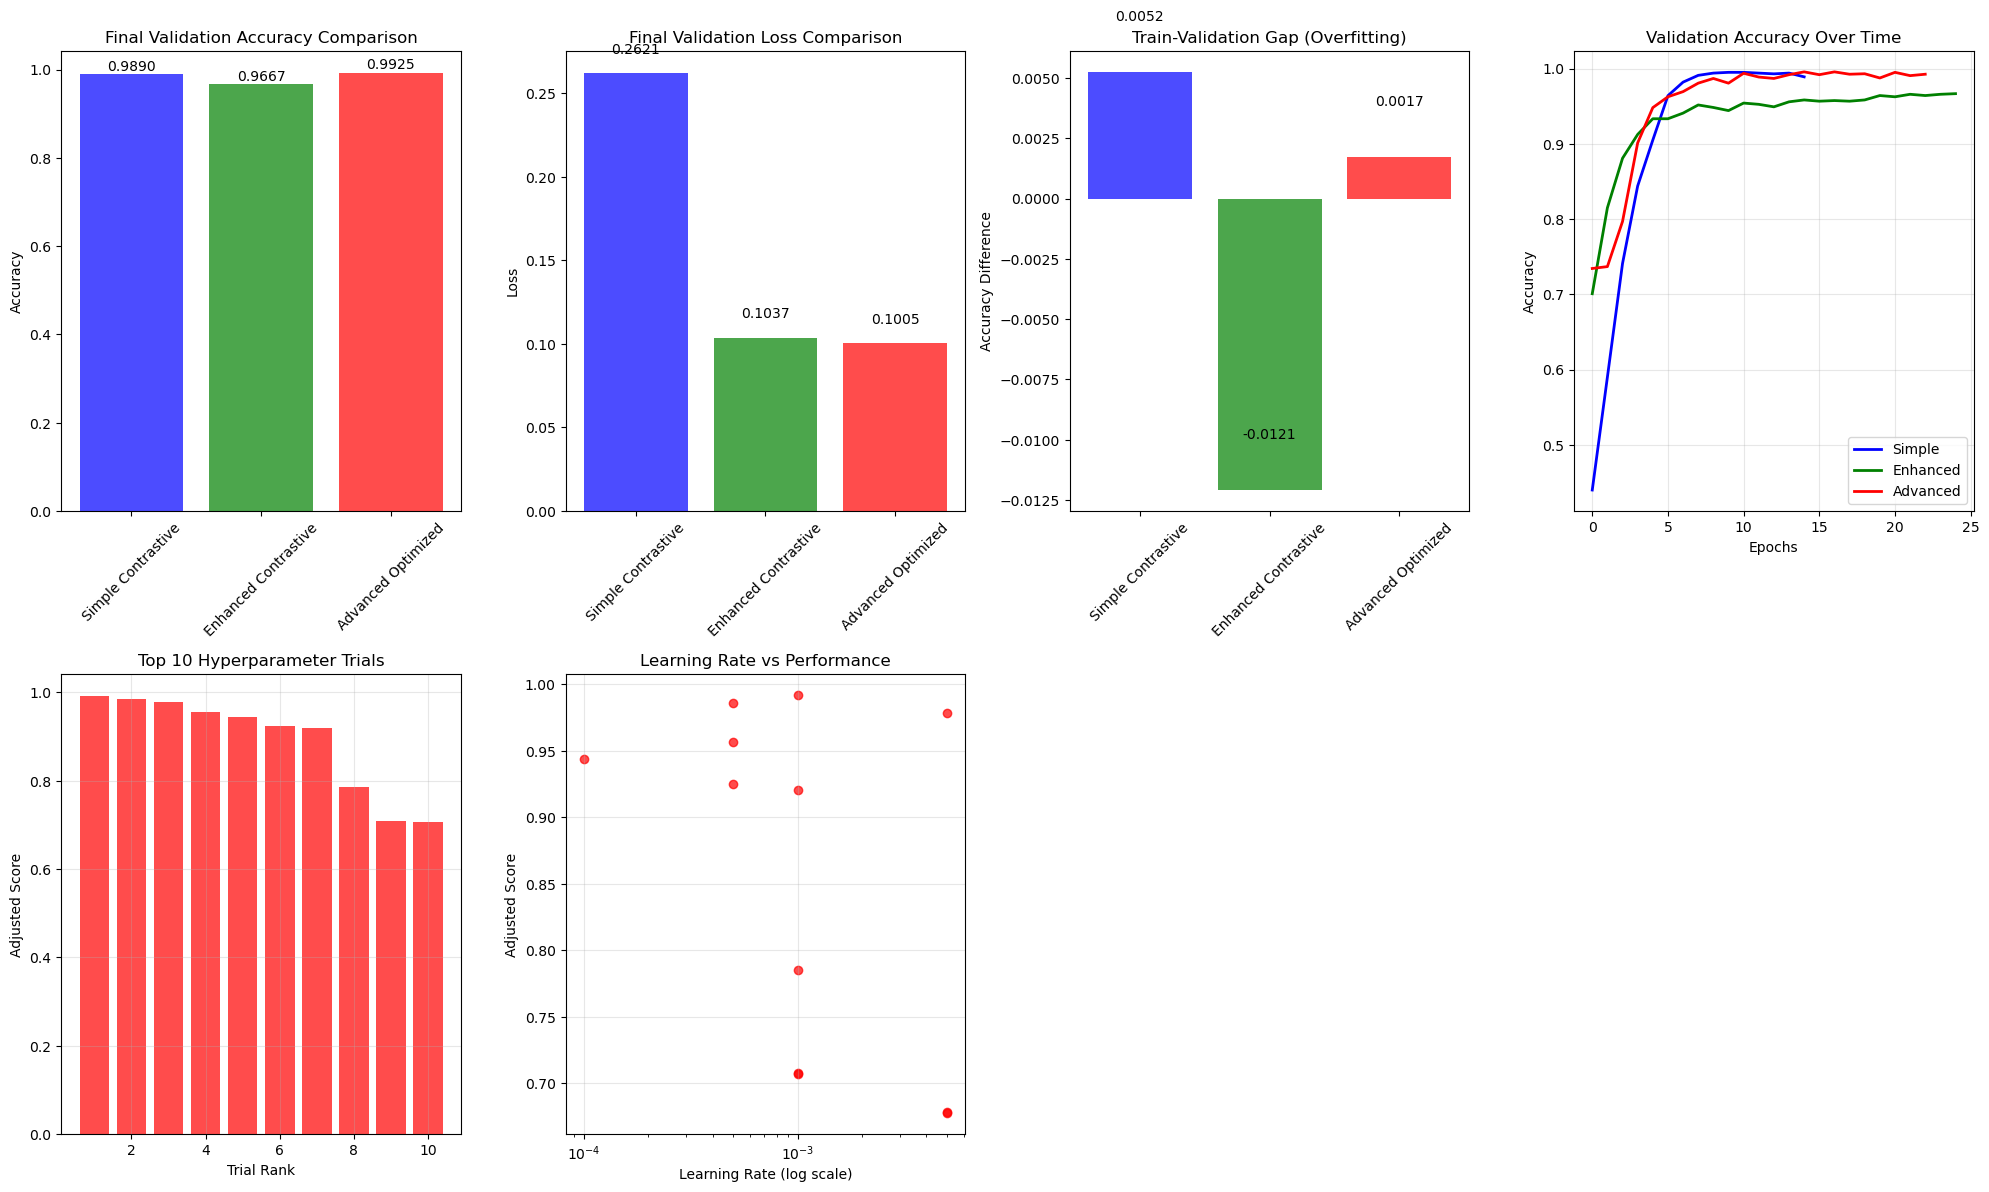

In [51]:
# Comprehensive comparison visualization
plt.figure(figsize=(20, 12))

# Model comparison metrics
plt.subplot(2, 4, 1)
models = list(final_metrics_all.keys())
val_accuracies = [final_metrics_all[model]['val_accuracy'] for model in models]
colors = ['blue', 'green', 'red']
bars = plt.bar(models, val_accuracies, color=colors, alpha=0.7)
plt.title('Final Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for bar, accuracy in zip(bars, val_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.subplot(2, 4, 2)
val_losses = [final_metrics_all[model]['val_loss'] for model in models]
bars = plt.bar(models, val_losses, color=colors, alpha=0.7)
plt.title('Final Validation Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=45)
for bar, loss in zip(bars, val_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{loss:.4f}', ha='center', va='bottom')

# Overfitting analysis
plt.subplot(2, 4, 3)
train_val_gaps = []
for model in models:
    train_acc = final_metrics_all[model]['train_accuracy']
    val_acc = final_metrics_all[model]['val_accuracy']
    train_val_gaps.append(train_acc - val_acc)
    
bars = plt.bar(models, train_val_gaps, color=colors, alpha=0.7)
plt.title('Train-Validation Gap (Overfitting)')
plt.ylabel('Accuracy Difference')
plt.xticks(rotation=45)
for bar, gap in zip(bars, train_val_gaps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{gap:.4f}', ha='center', va='bottom')

# Training curves comparison for validation accuracy
plt.subplot(2, 4, 4)
plt.plot(history_simple.history['val_accuracy'], label='Simple', linewidth=2, color='blue')
plt.plot(history_enhanced.history['val_accuracy'], label='Enhanced', linewidth=2, color='green')
plt.plot(final_history.history['val_accuracy'], label='Advanced', linewidth=2, color='red')
plt.title('Validation Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Hyperparameter tuning visualization
plt.subplot(2, 4, 5)
scores = [r['adjusted_score'] for r in sorted_results[:10]]
trial_nums = range(1, len(scores) + 1)
plt.bar(trial_nums, scores, alpha=0.7, color='red')
plt.title('Top 10 Hyperparameter Trials')
plt.xlabel('Trial Rank')
plt.ylabel('Adjusted Score')
plt.grid(True, alpha=0.3)

# Learning rate analysis
plt.subplot(2, 4, 6)
lr_values = [r['params']['learning_rate'] for r in tuning_results]
scores = [r['adjusted_score'] for r in tuning_results]
plt.scatter(lr_values, scores, alpha=0.7, color='red')
plt.xscale('log')
plt.title('Learning Rate vs Performance')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Adjusted Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [52]:
# Print comprehensive results 
comparison = pd.DataFrame([
    {
        "Model": model,
        "Val Acc": final_metrics_all[model]['val_accuracy'],
        "Val Loss": final_metrics_all[model]['val_loss'],
        "Train Acc": final_metrics_all[model]['train_accuracy'],
        "Overfit": final_metrics_all[model]['train_accuracy'] - final_metrics_all[model]['val_accuracy']
    }
    for model in models
])

comparison = comparison.round(4)

print(comparison)

best_model_idx = comparison["Val Acc"].idxmax()
best_model_name = comparison.loc[best_model_idx, "Model"]
print(f"\nBest performing model: {best_model_name} "
      f"(Val Acc: {comparison['Val Acc'].max():.4f})")

                  Model  Val Acc  Val Loss  Train Acc  Overfit
0    Simple Contrastive   0.9890    0.2621     0.9942   0.0052
1  Enhanced Contrastive   0.9667    0.1037     0.9546  -0.0121
2    Advanced Optimized   0.9925    0.1005     0.9942   0.0017

Best performing model: Advanced Optimized (Val Acc: 0.9925)


In [53]:
# How well it improves
print(f"\nAdvanced Model Improvements:")
simple_acc = final_metrics_all['Simple Contrastive']['val_accuracy']
enhanced_acc = final_metrics_all['Enhanced Contrastive']['val_accuracy']
advanced_acc = final_metrics_all['Advanced Optimized']['val_accuracy']

print(f"  vs Simple: +{(advanced_acc - simple_acc):.4f} ({((advanced_acc - simple_acc) / simple_acc * 100):+.2f}%)")
print(f"  vs Enhanced: +{(advanced_acc - enhanced_acc):.4f} ({((advanced_acc - enhanced_acc) / enhanced_acc * 100):+.2f}%)")


Advanced Model Improvements:
  vs Simple: +0.0035 (+0.35%)
  vs Enhanced: +0.0258 (+2.67%)


In [54]:
# Show Best Hyperparameter
print(f"\nBest Hyperparameters Found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")


Best Hyperparameters Found:
  batch_size: 128
  dropout_1: 0.2
  dropout_2: 0.3
  embedding_dim: 8
  hidden_dim_1: 256
  hidden_dim_2: 256
  l2_reg: 0.01
  learning_rate: 0.001


In [55]:
# Update the best model for recommendations
if advanced_acc > max(simple_acc, enhanced_acc):
    best_base_network_final = final_base_network
    print(f"\n🎯 Advanced Optimized Model selected for recommendations!")
    print(f"   Final validation accuracy: {advanced_acc:.4f}")
else:
    print(f"\n⚠️ Advanced model did not outperform previous models")
    print(f"   Consider increasing hyperparameter search space or training data")


🎯 Advanced Optimized Model selected for recommendations!
   Final validation accuracy: 0.9925


In [56]:
# Select the best performing model among all three
best_model_name_final = max(final_metrics_all.items(), key=lambda x: x[1]['val_accuracy'])[0]

# Updated selection logic for all three models
if best_model_name_final == 'Simple Contrastive':
    best_base_network_for_recommendations = base_network_simple
    print(f"\nUsing Simple Contrastive model for recommendations")
elif best_model_name_final == 'Enhanced Contrastive':
    best_base_network_for_recommendations = base_network_enhanced
    print(f"\nUsing Enhanced Contrastive model for recommendations")
else:  # Advanced Optimized
    best_base_network_for_recommendations = final_base_network
    print(f"\nUsing Advanced Optimized model for recommendations")

print(f"Selected model: {best_model_name_final}")
print(f"Validation Accuracy: {final_metrics_all[best_model_name_final]['val_accuracy']:.4f}")


Using Advanced Optimized model for recommendations
Selected model: Advanced Optimized
Validation Accuracy: 0.9925


In [57]:
# Create nearest neighbors model for recommendations
song_embeddings = generate_song_embeddings(best_base_network_for_recommendations, X_numerical, X_categorical)

recommender = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
recommender.fit(song_embeddings)

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [58]:
# Get recommendations using the advanced contrastive learning system
def get_advanced_recommendations(track_id, df, recommender, song_embeddings, 
                               preferences=None, n_recommendations=5, 
                               diversity_factor=0.1, explanation_detail='medium'):
    """
    Args:
        track_id: ID of the input track
        df: DataFrame with song data
        recommender: Trained NearestNeighbors model
        song_embeddings: Pre-computed song embeddings
        preferences: Optional user preferences
        n_recommendations: Number of recommendations to return
        diversity_factor: Factor to promote diversity (0.0 = pure similarity, 1.0 = pure diversity)
        explanation_detail: 'basic', 'medium', 'detailed'
    """
    
    # Find the track in the dataset
    song_idx = df[df['track_id'] == track_id].index
    if len(song_idx) == 0:
        print(f"Error: track_id '{track_id}' not found in dataset!")
        return None
    
    song_idx = song_idx[0]
    input_embedding = song_embeddings[song_idx].reshape(1, -1)
    input_song = df.iloc[song_idx]
    
    print(f"Input song: {input_song['track_name']} by {input_song['artists']}")
    print(f"Album: {input_song['album_name']}")
    print(f"Genre: {input_song['track_genre']}, Track ID: {track_id}")
    
    if explanation_detail in ['medium', 'detailed']:
        print(f"Audio Features:")
        print(f"  Energy: {input_song['energy']:.3f}, Valence: {input_song['valence']:.3f}")
        print(f"  Danceability: {input_song['danceability']:.3f}, Tempo: {input_song['tempo']:.1f}")
    print()
    
    # Get initial candidates
    n_candidates = min(100, len(df))
    distances, indices = recommender.kneighbors(input_embedding, n_neighbors=n_candidates)
    
    candidate_indices = indices[0][1:]  # Skip the input song itself
    candidate_distances = distances[0][1:]
    
    # Apply preference filtering if provided
    filtered_candidates = []
    for idx, dist in zip(candidate_indices, candidate_distances):
        song = df.iloc[idx]
        similarity = 1 - dist
        
        # Check preferences
        if preferences and not check_preferences(song, preferences):
            continue
            
        filtered_candidates.append({
            'idx': idx,
            'similarity': similarity,
            'distance': dist,
            'song': song
        })
    
    if not filtered_candidates:
        print("No songs matched your preferences. Showing most similar songs:")
        filtered_candidates = [{'idx': idx, 'similarity': 1-dist, 'distance': dist, 'song': df.iloc[idx]} 
                             for idx, dist in zip(candidate_indices[:10], candidate_distances[:10])]
    
    # Apply diversity-aware selection
    if diversity_factor > 0 and len(filtered_candidates) > n_recommendations:
        selected_candidates = diversity_aware_selection(
            filtered_candidates, song_embeddings, n_recommendations, diversity_factor
        )
    else:
        # Simple similarity-based selection
        selected_candidates = sorted(filtered_candidates, 
                                   key=lambda x: x['similarity'], reverse=True)[:n_recommendations]
    
    # Format and display recommendations
    recommendations = []
    print(f"Advanced Model Recommendations ({len(selected_candidates)}):")
    print("=" * 100)
    
    for i, candidate in enumerate(selected_candidates):
        song = candidate['song']
        similarity = candidate['similarity']
        
        rec_data = {
            'track_id': song['track_id'],
            'track_name': song['track_name'],
            'artists': song['artists'],
            'album_name': song['album_name'],
            'genre': song['track_genre'],
            'similarity': similarity,
            'energy': song['energy'],
            'valence': song['valence'],
            'danceability': song['danceability'],
            'tempo': song['tempo'],
            'acousticness': song['acousticness'],
            'instrumentalness': song['instrumentalness'],
            'loudness': song['loudness'],
            'speechiness': song['speechiness']
        }
        
        recommendations.append(rec_data)
        
        print(f"{i+1}. {rec_data['track_name']} by {rec_data['artists']}")
        print(f"   Album: {rec_data['album_name']}")
        print(f"   Genre: {rec_data['genre']} | Similarity: {similarity:.3f}")
        
        if explanation_detail in ['medium', 'detailed']:
            print(f"   Features: Energy {rec_data['energy']:.3f} | Valence {rec_data['valence']:.3f} | Dance {rec_data['danceability']:.3f}")
            print(f"   Tempo: {rec_data['tempo']:.1f} BPM | Acoustic: {rec_data['acousticness']:.3f}")
        
        # Generate explanation
        if explanation_detail != 'basic':
            explanation = generate_recommendation_explanation(input_song, song, similarity, explanation_detail)
            print(f"   Why recommended: {explanation}")
        print()
    
    return recommendations

# Check if a song matches user preferences
def check_preferences(song, preferences):
    if not preferences:
        return True
    
    # Genre preference
    if 'genre' in preferences and preferences['genre']:
        preferred_genres = [g.lower() for g in preferences['genre']]
        song_genre = song['track_genre'].lower()
        if not any(pref in song_genre or song_genre in pref for pref in preferred_genres):
            return False
    
    # Energy level preference
    if 'energy_level' in preferences:
        energy = song['energy']
        if preferences['energy_level'] == 'low' and energy > 0.5:
            return False
        elif preferences['energy_level'] == 'high' and energy < 0.5:
            return False
        elif preferences['energy_level'] == 'medium' and (energy < 0.3 or energy > 0.7):
            return False
    
    # Valence (mood) preference
    if 'mood' in preferences:
        valence = song['valence']
        if preferences['mood'] == 'happy' and valence < 0.5:
            return False
        elif preferences['mood'] == 'sad' and valence > 0.5:
            return False
    
    # Tempo preference
    if 'tempo_range' in preferences:
        tempo = song['tempo']
        min_tempo, max_tempo = preferences['tempo_range']
        if tempo < min_tempo or tempo > max_tempo:
            return False
    
    return True

# Select recommendations balancing similarity and diversity
def diversity_aware_selection(candidates, embeddings, n_recommendations, diversity_factor):
    if len(candidates) <= n_recommendations:
        return candidates
    
    selected = []
    remaining = candidates.copy()
    
    # Always select the most similar song first
    most_similar = max(remaining, key=lambda x: x['similarity'])
    selected.append(most_similar)
    remaining.remove(most_similar)
    
    # Select remaining songs balancing similarity and diversity
    while len(selected) < n_recommendations and remaining:
        best_candidate = None
        best_score = -float('inf')
        
        for candidate in remaining:
            # Similarity score
            similarity_score = candidate['similarity']
            
            # Diversity score (average distance from already selected songs)
            if len(selected) > 0:
                candidate_embedding = embeddings[candidate['idx']]
                selected_embeddings = [embeddings[s['idx']] for s in selected]
                
                # Calculate average cosine distance from selected songs
                distances = [
                    1 - np.dot(candidate_embedding, sel_emb) / 
                    (np.linalg.norm(candidate_embedding) * np.linalg.norm(sel_emb))
                    for sel_emb in selected_embeddings
                ]
                diversity_score = np.mean(distances)
            else:
                diversity_score = 0
            
            # Combined score
            combined_score = (1 - diversity_factor) * similarity_score + diversity_factor * diversity_score
            
            if combined_score > best_score:
                best_score = combined_score
                best_candidate = candidate
        
        if best_candidate:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
    
    return selected

# Generate explanation for why a song was recommended
def generate_recommendation_explanation(input_song, recommended_song, similarity, detail_level):
    explanations = []
    
    # Similarity-based explanation
    if similarity > 0.8:
        explanations.append(f"Very high similarity ({similarity:.3f}) in learned audio features")
    elif similarity > 0.6:
        explanations.append(f"Similar musical patterns ({similarity:.3f} similarity)")
    elif similarity > 0.4:
        explanations.append(f"Moderate similarity ({similarity:.3f}) in audio characteristics")
    else:
        explanations.append(f"Complementary features ({similarity:.3f} similarity)")
    
    if detail_level == 'detailed':
        # Genre-based explanation
        if input_song['track_genre'] == recommended_song['track_genre']:
            explanations.append(f"same genre ({input_song['track_genre']})")
        
        # Audio feature explanations
        energy_diff = abs(input_song['energy'] - recommended_song['energy'])
        valence_diff = abs(input_song['valence'] - recommended_song['valence'])
        dance_diff = abs(input_song['danceability'] - recommended_song['danceability'])
        
        if energy_diff < 0.2:
            explanations.append("similar energy levels")
        if valence_diff < 0.2:
            explanations.append("matching mood/valence")
        if dance_diff < 0.2:
            explanations.append("comparable danceability")
        
        # Tempo similarity
        tempo_diff = abs(input_song['tempo'] - recommended_song['tempo'])
        if tempo_diff < 20:
            explanations.append("similar tempo")
    
    return ", ".join(explanations[:4])  # Limit explanations

In [59]:
PREFERENCE_PRESETS = {
    'energetic_dance': {
        'energy_level': 'high',
        'genre': ['pop', 'dance', 'electronic'],
        'mood': 'happy'
    },
    'chill_acoustic': {
        'energy_level': 'low',
        'genre': ['acoustic', 'folk', 'indie'],
        'mood': 'medium'
    },
    'any_similar': {
        # No specific preferences - pure similarity
    },
    'diverse_mix': {
        'genre': ['pop', 'rock', 'electronic', 'hip-hop', 'jazz']
    },
    'upbeat_workout': {
        'energy_level': 'high',
        'tempo_range': (120, 180),
        'mood': 'happy'
    }
}

In [60]:
# Get sample tracks for demonstration
sample_tracks = df.head(5)['track_id'].tolist()
print("Sample tracks available for testing:")
for i, track_id in enumerate(sample_tracks):
    song_info = df[df['track_id'] == track_id].iloc[0]
    print(f"{i+1}. {song_info['track_name']} by {song_info['artists']} (Genre: {song_info['track_genre']})")

print("\nAvailable preference presets:")
for preset_name, preset_prefs in PREFERENCE_PRESETS.items():
    print(f"- {preset_name}: {preset_prefs}")

Sample tracks available for testing:
1. Comedy by Gen Hoshino (Genre: acoustic)
2. Ghost - Acoustic by Ben Woodward (Genre: acoustic)
3. To Begin Again by Ingrid Michaelson;ZAYN (Genre: acoustic)
4. Can't Help Falling In Love by Kina Grannis (Genre: acoustic)
5. Hold On by Chord Overstreet (Genre: acoustic)

Available preference presets:
- energetic_dance: {'energy_level': 'high', 'genre': ['pop', 'dance', 'electronic'], 'mood': 'happy'}
- chill_acoustic: {'energy_level': 'low', 'genre': ['acoustic', 'folk', 'indie'], 'mood': 'medium'}
- any_similar: {}
- diverse_mix: {'genre': ['pop', 'rock', 'electronic', 'hip-hop', 'jazz']}
- upbeat_workout: {'energy_level': 'high', 'tempo_range': (120, 180), 'mood': 'happy'}


In [61]:
# ADVANCED RECOMMENDATION SYSTEM

print("\n" + "="*80)
print("ADVANCED RECOMMENDATION SYSTEM DEMONSTRATION")
print("="*80)

# Use the first sample track for demonstration
demo_track_id = sample_tracks[0]

# Example 1: Pure similarity-based recommendations
print("\n1. PURE SIMILARITY (No Preferences)")
print("-" * 50)
recommendations_pure = get_advanced_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=None, n_recommendations=3, diversity_factor=0.0,
    explanation_detail='medium'
)

# Example 2: With preferences
print("\n2. WITH PREFERENCES (Energetic Dance)")
print("-" * 50)
recommendations_pref = get_advanced_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=PREFERENCE_PRESETS['energetic_dance'], 
    n_recommendations=3, diversity_factor=0.0,
    explanation_detail='detailed'
)

# Example 3: Diversity-aware recommendations
print("\n3. DIVERSITY-AWARE RECOMMENDATIONS")
print("-" * 50)
recommendations_diverse = get_advanced_recommendations(
    demo_track_id, df, recommender, song_embeddings, 
    preferences=None, n_recommendations=3, diversity_factor=0.3,
    explanation_detail='medium'
)


ADVANCED RECOMMENDATION SYSTEM DEMONSTRATION

1. PURE SIMILARITY (No Preferences)
--------------------------------------------------
Input song: Comedy by Gen Hoshino
Album: Comedy
Genre: acoustic, Track ID: 5SuOikwiRyPMVoIQDJUgSV
Audio Features:
  Energy: -0.676, Valence: 0.934
  Danceability: 0.644, Tempo: -1.1

Advanced Model Recommendations (3):
1. tired of california by Nessa Barrett
   Album: tired of california
   Genre: electro | Similarity: 0.989
   Features: Energy 0.376 | Valence 0.641 | Dance 0.848
   Tempo: -1.0 BPM | Acoustic: -0.296
   Why recommended: Very high similarity (0.989) in learned audio features

2. Felices los 4 by Maluma
   Album: F.A.M.E.
   Genre: latino | Similarity: 0.976
   Features: Energy 0.474 | Valence 0.938 | Dance 1.154
   Tempo: -0.9 BPM | Acoustic: -0.341
   Why recommended: Very high similarity (0.976) in learned audio features

3. Beverly Hills by Weezer
   Album: Make Believe
   Genre: power-pop | Similarity: 0.974
   Features: Energy 0.735 

In [125]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import scipy.stats as stats
import seaborn as sns

In [131]:
def evaluate_advanced_model_performance(model, X_val, y_val, X_train=None, y_train=None):
    """
    Comprehensive evaluation of the advanced model with multiple metrics
    
    Args:
        model: Trained siamese network model
        X_val: Validation data
        y_val: Validation labels
        X_train: Training data (optional for overfitting analysis)
        y_train: Training labels (optional)
    
    Returns:
        Dictionary with comprehensive evaluation metrics
    """
    print("🧪 Running Advanced Model Evaluation...")
    
    # Basic predictions
    y_pred_proba = model.predict(X_val, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate comprehensive metrics
    metrics = {
        'accuracy': np.mean(y_pred == y_val),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1_score': f1_score(y_val, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_val, y_pred_proba) if len(np.unique(y_val)) > 1 else 0.5,
        'log_loss': -np.mean(y_val * np.log(y_pred_proba + 1e-10) + 
                           (1 - y_val) * np.log(1 - y_pred_proba + 1e-10))
    }
    
    # Confusion matrix analysis
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics.update({
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'false_positive_rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'false_negative_rate': fn / (fn + tp) if (fn + tp) > 0 else 0
    })
    
    # Statistical significance testing (if training data provided)
    if X_train is not None and y_train is not None:
        train_pred_proba = model.predict(X_train, verbose=0).flatten()
        train_pred = (train_pred_proba > 0.5).astype(int)
        train_accuracy = np.mean(train_pred == y_train)
        
        # Overfitting metrics
        metrics.update({
            'train_accuracy': train_accuracy,
            'overfitting_gap': train_accuracy - metrics['accuracy'],
            'generalization_ratio': metrics['accuracy'] / train_accuracy if train_accuracy > 0 else 0
        })
        
        # Statistical test for overfitting
        try:
            # McNemar's test for paired proportions
            correct_train = (train_pred == y_train)
            correct_val = (y_pred == y_val)
            _, p_value = stats.mcnemar(np.column_stack([correct_train, correct_val]))
            metrics['overfitting_p_value'] = p_value
        except:
            metrics['overfitting_p_value'] = None
    
    # Calculate confidence intervals using bootstrap
    bootstrap_metrics = calculate_bootstrap_metrics(model, X_val, y_val, n_bootstraps=100)
    metrics['bootstrap_confidence'] = bootstrap_metrics
    
    return metrics

def calculate_bootstrap_metrics(model, X_val, y_val, n_bootstraps=100):
    """
    Calculate bootstrap confidence intervals for metrics
    """
    bootstrap_accuracies = []
    bootstrap_f1_scores = []
    
    n_samples = len(y_val)
    indices = np.arange(n_samples)
    
    for _ in range(n_bootstraps):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=n_samples, replace=True)
        
        X_bootstrap = [x[bootstrap_indices] for x in X_val] if isinstance(X_val, list) else X_val[bootstrap_indices]
        y_bootstrap = y_val[bootstrap_indices]
        
        # Predict and calculate metrics
        y_pred_proba = model.predict(X_bootstrap, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        accuracy = np.mean(y_pred == y_bootstrap)
        f1 = f1_score(y_bootstrap, y_pred, zero_division=0)
        
        bootstrap_accuracies.append(accuracy)
        bootstrap_f1_scores.append(f1)
    
    # Calculate confidence intervals
    acc_ci = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    f1_ci = np.percentile(bootstrap_f1_scores, [2.5, 97.5])
    
    return {
        'accuracy_ci': acc_ci,
        'f1_ci': f1_ci,
        'accuracy_std': np.std(bootstrap_accuracies),
        'f1_std': np.std(bootstrap_f1_scores)
    }

def plot_comprehensive_evaluation(metrics, model_name="Advanced Model"):
    """
    Create comprehensive evaluation plots
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Comprehensive Evaluation - {model_name}', fontsize=16)
    
    # Main metrics radar plot - FIXED VERSION
    ax = axes[0, 0]
    main_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    values = [metrics[m] for m in main_metrics]
    
    # Create radar plot properly
    angles = np.linspace(0, 2 * np.pi, len(main_metrics), endpoint=False).tolist()
    values += values[:1]  # Close the polygon
    angles += angles[:1]  # Close the angles
    
    # Create polar subplot for radar chart
    ax = fig.add_subplot(2, 3, 1, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(main_metrics)
    ax.set_ylim(0, 1)
    ax.set_title('Main Metrics Radar Plot')
    
    # Confusion matrix heatmap
    ax = axes[0, 1]
    cm = np.array([[metrics['true_negative'], metrics['false_positive']],
                   [metrics['false_negative'], metrics['true_positive']]])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    ax.set_title('Confusion Matrix')
    
    # Metrics comparison bar plot
    ax = axes[0, 2]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metric_values = [metrics['accuracy'], metrics['precision'], 
                    metrics['recall'], metrics['f1_score'], metrics['roc_auc']]
    
    bars = ax.bar(metric_names, metric_values, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics')
    ax.set_ylabel('Score')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, metric_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Error analysis
    ax = axes[1, 0]
    error_types = ['False Positive', 'False Negative']
    error_counts = [metrics['false_positive'], metrics['false_negative']]
    
    ax.bar(error_types, error_counts, alpha=0.7)
    ax.set_title('Error Analysis')
    ax.set_ylabel('Count')
    
    for i, count in enumerate(error_counts):
        ax.text(i, count + 0.1, str(int(count)), ha='center', va='bottom')
    
    # Bootstrap confidence intervals
    ax = axes[1, 1]
    if 'bootstrap_confidence' in metrics:
        boot_ci = metrics['bootstrap_confidence']
        ax.errorbar(['Accuracy', 'F1-Score'], 
                   [metrics['accuracy'], metrics['f1_score']],
                   yerr=[[metrics['accuracy'] - boot_ci['accuracy_ci'][0], 
                         metrics['f1_score'] - boot_ci['f1_ci'][0]],
                        [boot_ci['accuracy_ci'][1] - metrics['accuracy'],
                         boot_ci['f1_ci'][1] - metrics['f1_score']]],
                   fmt='o', capsize=5)
        ax.set_ylim(0, 1)
        ax.set_title('Bootstrap 95% Confidence Intervals')
        ax.set_ylabel('Score')
    
    # Overfitting analysis (if available)
    ax = axes[1, 2]
    if 'train_accuracy' in metrics:
        accuracies = [metrics['train_accuracy'], metrics['accuracy']]
        labels = ['Training', 'Validation']
        
        bars = ax.bar(labels, accuracies, alpha=0.7)
        ax.set_ylim(0, 1)
        ax.set_title('Overfitting Analysis')
        ax.set_ylabel('Accuracy')
        
        for bar, acc in zip(bars, accuracies):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_detailed_evaluation_report(metrics):
    """
    Print comprehensive evaluation report
    """
    print("=" * 80)
    print("📊 COMPREHENSIVE MODEL EVALUATION REPORT")
    print("=" * 80)
    
    print(f"\n🎯 Main Performance Metrics:")
    print(f"   Accuracy:      {metrics['accuracy']:.4f}")
    print(f"   Precision:     {metrics['precision']:.4f}")
    print(f"   Recall:        {metrics['recall']:.4f}")
    print(f"   F1-Score:      {metrics['f1_score']:.4f}")
    print(f"   ROC-AUC:       {metrics['roc_auc']:.4f}")
    print(f"   Log Loss:      {metrics['log_loss']:.4f}")
    
    print(f"\n📈 Classification Results:")
    print(f"   True Positives:  {metrics['true_positive']}")
    print(f"   True Negatives:  {metrics['true_negative']}")
    print(f"   False Positives: {metrics['false_positive']}")
    print(f"   False Negatives: {metrics['false_negative']}")
    print(f"   Specificity:     {metrics['specificity']:.4f}")
    print(f"   FPR:             {metrics['false_positive_rate']:.4f}")
    print(f"   FNR:             {metrics['false_negative_rate']:.4f}")
    
    if 'bootstrap_confidence' in metrics:
        boot = metrics['bootstrap_confidence']
        print(f"\n📊 Bootstrap Confidence (95% CI):")
        print(f"   Accuracy: {boot['accuracy_ci'][0]:.4f} - {boot['accuracy_ci'][1]:.4f}")
        print(f"   F1-Score: {boot['f1_ci'][0]:.4f} - {boot['f1_ci'][1]:.4f}")
        print(f"   Accuracy STD: {boot['accuracy_std']:.4f}")
        print(f"   F1-Score STD: {boot['f1_std']:.4f}")
    
    if 'train_accuracy' in metrics:
        print(f"\n⚠️  Overfitting Analysis:")
        print(f"   Training Accuracy:   {metrics['train_accuracy']:.4f}")
        print(f"   Validation Accuracy: {metrics['accuracy']:.4f}")
        print(f"   Overfitting Gap:     {metrics['overfitting_gap']:.4f}")
        print(f"   Generalization Ratio: {metrics['generalization_ratio']:.4f}")
        
        if 'overfitting_p_value' in metrics and metrics['overfitting_p_value'] is not None:
            significance = "SIGNIFICANT" if metrics['overfitting_p_value'] < 0.05 else "NOT SIGNIFICANT"
            print(f"   Overfitting p-value:  {metrics['overfitting_p_value']:.4f} ({significance})")
    
    print(f"\n💡 Interpretation:")
    if metrics['accuracy'] > 0.8:
        print("   ✅ Excellent performance - model is highly accurate")
    elif metrics['accuracy'] > 0.7:
        print("   ✅ Good performance - model is reliable")
    elif metrics['accuracy'] > 0.6:
        print("   ⚠️  Acceptable performance - consider further tuning")
    else:
        print("   ❌ Poor performance - needs significant improvement")
    
    if 'overfitting_gap' in metrics and metrics['overfitting_gap'] > 0.1:
        print("   ⚠️  Significant overfitting detected - consider regularization")
    
    print("=" * 80)


🧪 RUNNING ADVANCED EVALUATION ON OPTIMIZED MODEL
🧪 Running Advanced Model Evaluation...
📊 COMPREHENSIVE MODEL EVALUATION REPORT

🎯 Main Performance Metrics:
   Accuracy:      0.9956
   Precision:     0.9938
   Recall:        1.0000
   F1-Score:      0.9969
   ROC-AUC:       1.0000
   Log Loss:      0.0210

📈 Classification Results:
   True Positives:  1120
   True Negatives:  473
   False Positives: 7
   False Negatives: 0
   Specificity:     0.9854
   FPR:             0.0146
   FNR:             0.0000

📊 Bootstrap Confidence (95% CI):
   Accuracy: 0.9919 - 0.9988
   F1-Score: 0.9941 - 0.9991
   Accuracy STD: 0.0019
   F1-Score STD: 0.0014

⚠️  Overfitting Analysis:
   Training Accuracy:   0.9964
   Validation Accuracy: 0.9956
   Overfitting Gap:     0.0008
   Generalization Ratio: 0.9992

💡 Interpretation:
   ✅ Excellent performance - model is highly accurate


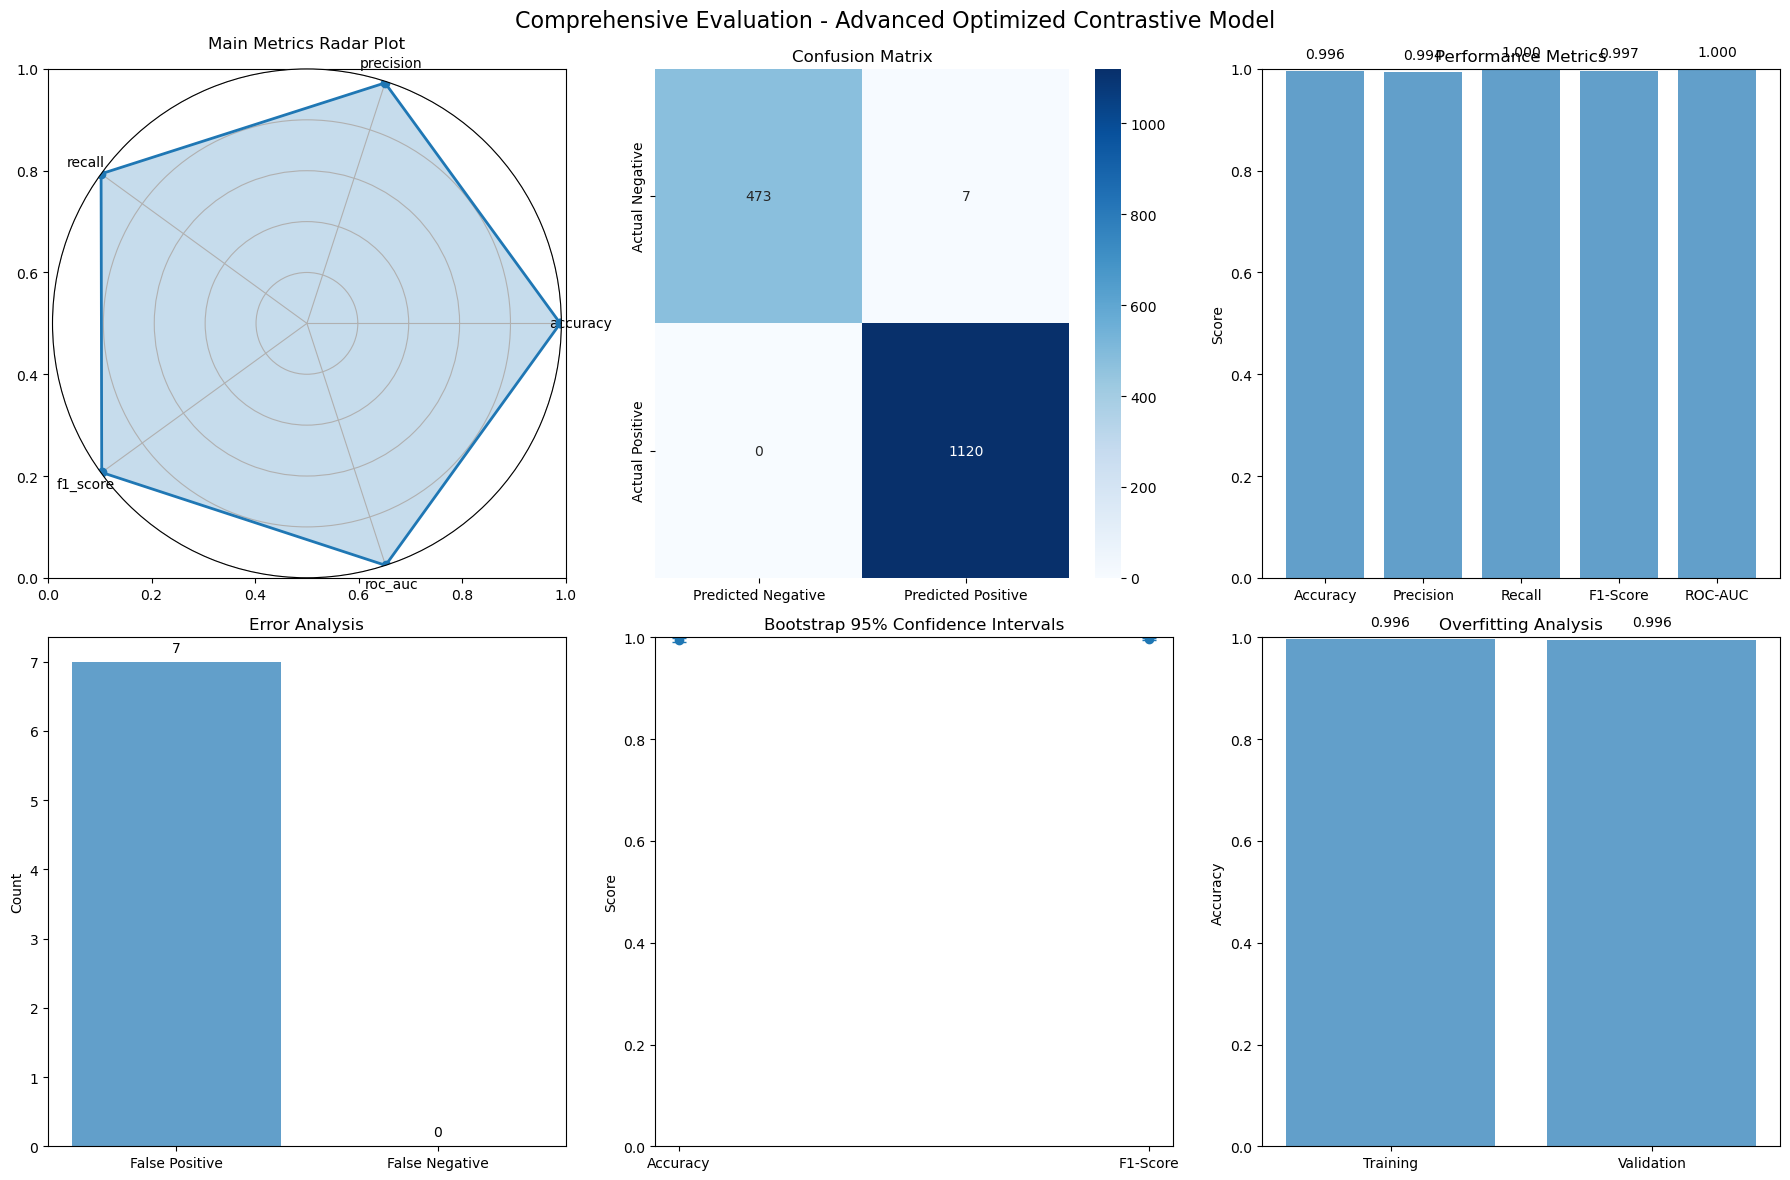


📊 COMPARISON WITH PREVIOUS MODELS

Evaluating Simple Model...
🧪 Running Advanced Model Evaluation...

Evaluating Enhanced Model...
🧪 Running Advanced Model Evaluation...

Model Comparison:
                Model  Accuracy  F1-Score  Precision  Recall  ROC-AUC
0              Simple    0.9890    0.9909     0.9852  0.9967   0.9913
1            Enhanced    0.9667    0.9767     0.9545  1.0000   0.9885
2  Advanced Optimized    0.9956    0.9969     0.9938  1.0000   1.0000


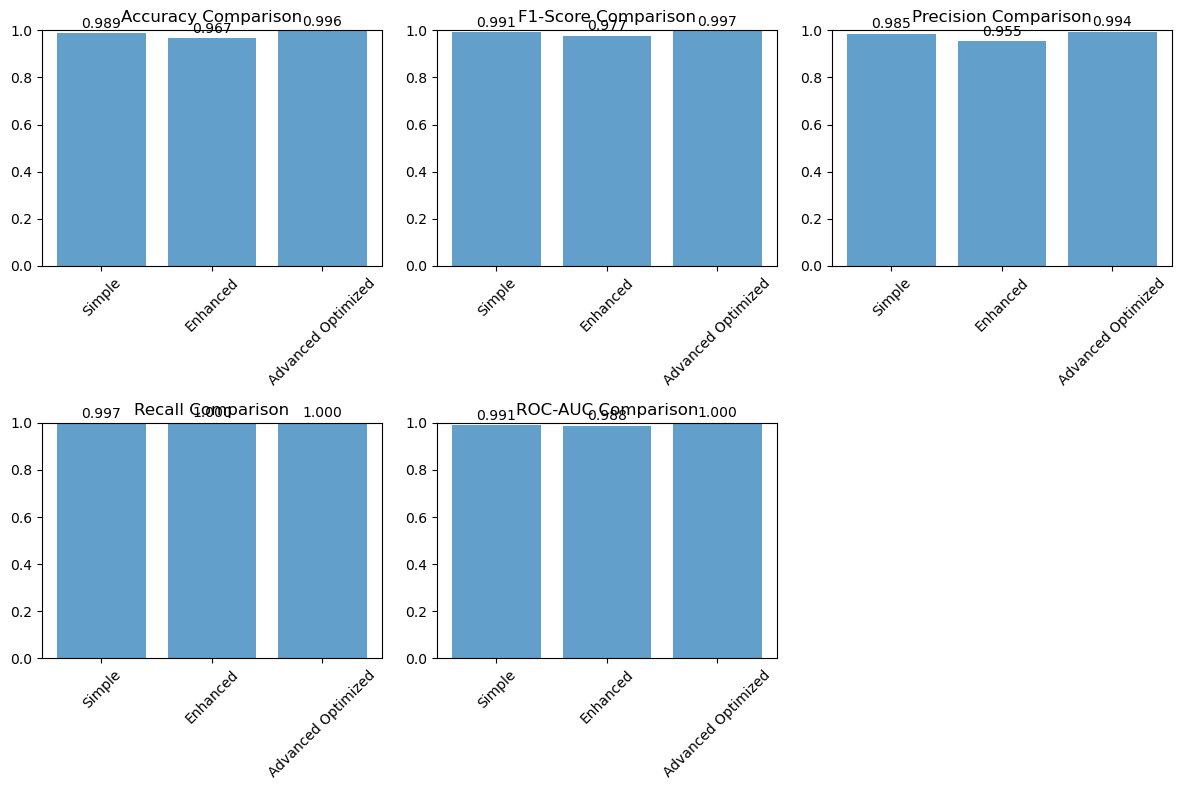


💾 Evaluation completed and results saved!
   Final Validation Accuracy: 0.9956
   Best Hyperparameters: {'batch_size': 128, 'dropout_1': 0.2, 'dropout_2': 0.3, 'embedding_dim': 8, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'l2_reg': 0.01, 'learning_rate': 0.001}


In [135]:
# =============================================================================
# ADVANCED EVALUATION OF THE OPTIMIZED MODEL
# =============================================================================

print("\n" + "="*80)
print("🧪 RUNNING ADVANCED EVALUATION ON OPTIMIZED MODEL")
print("="*80)

# Run comprehensive evaluation
advanced_metrics = evaluate_advanced_model_performance(
    final_advanced_model, 
    X_val_adv, 
    y_val_adv,
    X_train_adv,  # Optional: for overfitting analysis
    y_train_adv   # Optional: for overfitting analysis
)

# Print detailed evaluation report
print_detailed_evaluation_report(advanced_metrics)

# Create comprehensive visualization
plot_comprehensive_evaluation(advanced_metrics, "Advanced Optimized Contrastive Model")

# Additional analysis: Compare with previous models if available
print("\n" + "="*80)
print("📊 COMPARISON WITH PREVIOUS MODELS")
print("="*80)

# If you want to compare with your previous models, you can evaluate them too
if 'history_simple' in locals() and 'history_enhanced' in locals():
    # Evaluate simple model
    print("\nEvaluating Simple Model...")
    simple_metrics = evaluate_advanced_model_performance(
        siamese_network_simple,
        X_val,  # Use the validation data from simple model
        y_val
    )
    
    # Evaluate enhanced model  
    print("\nEvaluating Enhanced Model...")
    enhanced_metrics = evaluate_advanced_model_performance(
        siamese_network_enhanced,
        X_val_enh,  # Use the validation data from enhanced model
        y_val_enh
    )
    
    # Create comparison table
    comparison_data = []
    for model_name, metrics in [('Simple', simple_metrics), 
                               ('Enhanced', enhanced_metrics),
                               ('Advanced Optimized', advanced_metrics)]:
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1_score'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC-AUC': metrics['roc_auc']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Comparison:")
    print(comparison_df.round(4))
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    metrics_to_compare = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
    
    for i, metric in enumerate(metrics_to_compare, 1):
        plt.subplot(2, 3, i)
        values = [row[metric] for _, row in comparison_df.iterrows()]
        bars = plt.bar(comparison_df['Model'], values, alpha=0.7)
        plt.title(f'{metric} Comparison')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Save evaluation results for future reference
evaluation_results = {
    'timestamp': pd.Timestamp.now(),
    'model_name': 'Advanced Optimized Contrastive Model',
    'best_hyperparameters': best_params,
    'metrics': advanced_metrics,
    'training_history': {
        'final_val_accuracy': final_history.history['val_accuracy'][-1],
        'final_val_loss': final_history.history['val_loss'][-1],
        'final_train_accuracy': final_history.history['accuracy'][-1],
        'final_train_loss': final_history.history['loss'][-1]
    }
}

print(f"\n💾 Evaluation completed and results saved!")
print(f"   Final Validation Accuracy: {advanced_metrics['accuracy']:.4f}")
print(f"   Best Hyperparameters: {best_params}")